# YOLO Windshield Detection Training and Evaluation

This notebook demonstrates the complete workflow for training and evaluating a YOLO model. It includes:
- Loading and visualizing data
- Training the model
- Visualizing training progress
- Validating the model on a validation set
- Testing the model on a test set
- Analyzing results through confusion matrices and performance metrics


In [ ]:
import os
import cv2
from ultralytics import YOLO
from IPython.display import Image,display
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Visualizing Images with Bounding Boxes

This section displays images with their corresponding bounding boxes to ensure that the dataset is correctly annotated. 
Bounding boxes are converted from YOLO format to pixel coordinates for visualization.


In [ ]:

# Define the directories for images and annotations
image_dir = ''  # Update this path if needed
annotation_dir = ''  # Ensure your annotation files are stored here

# Function to display images with bounding boxes
def display_bounding_boxes(image_dir, annotation_dir):
    if not os.path.isdir(image_dir):
        print(f"Image directory '{image_dir}' not found.")
        return
    if not os.path.isdir(annotation_dir):
        print(f"Annotation directory '{annotation_dir}' not found.")
        return

    print(f"Processing images in directory: {image_dir}")
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.jpg') or img_name.endswith('.png'):
            # Load image
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not load image: {img_path}")
                continue

            h, w, _ = img.shape
            print(f"Loaded image: {img_path} with dimensions (width={w}, height={h})")

            # Load corresponding bounding box file
            label_path = os.path.join(annotation_dir, os.path.splitext(img_name)[0] + '.txt')
            if os.path.exists(label_path):
                with open(label_path, 'r') as file:
                    for line in file:
                        label = line.strip().split()
                        if len(label) == 5:
                            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label)
                            # Convert YOLO format to bounding box coordinates
                            x1 = int((x_center - bbox_width / 2) * w)
                            y1 = int((y_center - bbox_height / 2) * h)
                            x2 = int((x_center + bbox_width / 2) * w)
                            y2 = int((y_center + bbox_height / 2) * h)

                            # Draw the bounding box
                            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                            # Display class label
                            cv2.putText(img, 'windshield', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                print(f"Bounding box file not found for image: {img_name}")
                continue

            # Display the image with bounding boxes
            cv2.imshow('Bounding Box', img)
            cv2.waitKey(0)

    cv2.destroyAllWindows()

# Run the function on the specified directories
display_bounding_boxes(image_dir, annotation_dir)


## Device Configuration

This section checks whether a GPU is available and sets the device accordingly. If a GPU is available, the model will use it for faster computation.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')


Using cuda device


## Model Training

The YOLO model is trained using the following hyperparameters:
- Epochs: 120
- Batch Size: 8
- Image Size: 640

The training progress will be visualized through loss curves, precision-recall curves, and confusion matrices.
Results and weights will be saved in the `../runs/train` directory.


In [ ]:
model = YOLO('yolo11n.pt')  
model.train(data='data.yaml', epochs=120, imgsz=640, device=device, batch=8, plots=True,project="../runs",name="train")

## Training Progress Visualization

### Loss Curves
The loss curves help monitor the model's learning during training. Lower loss values indicate better fitting to the data.


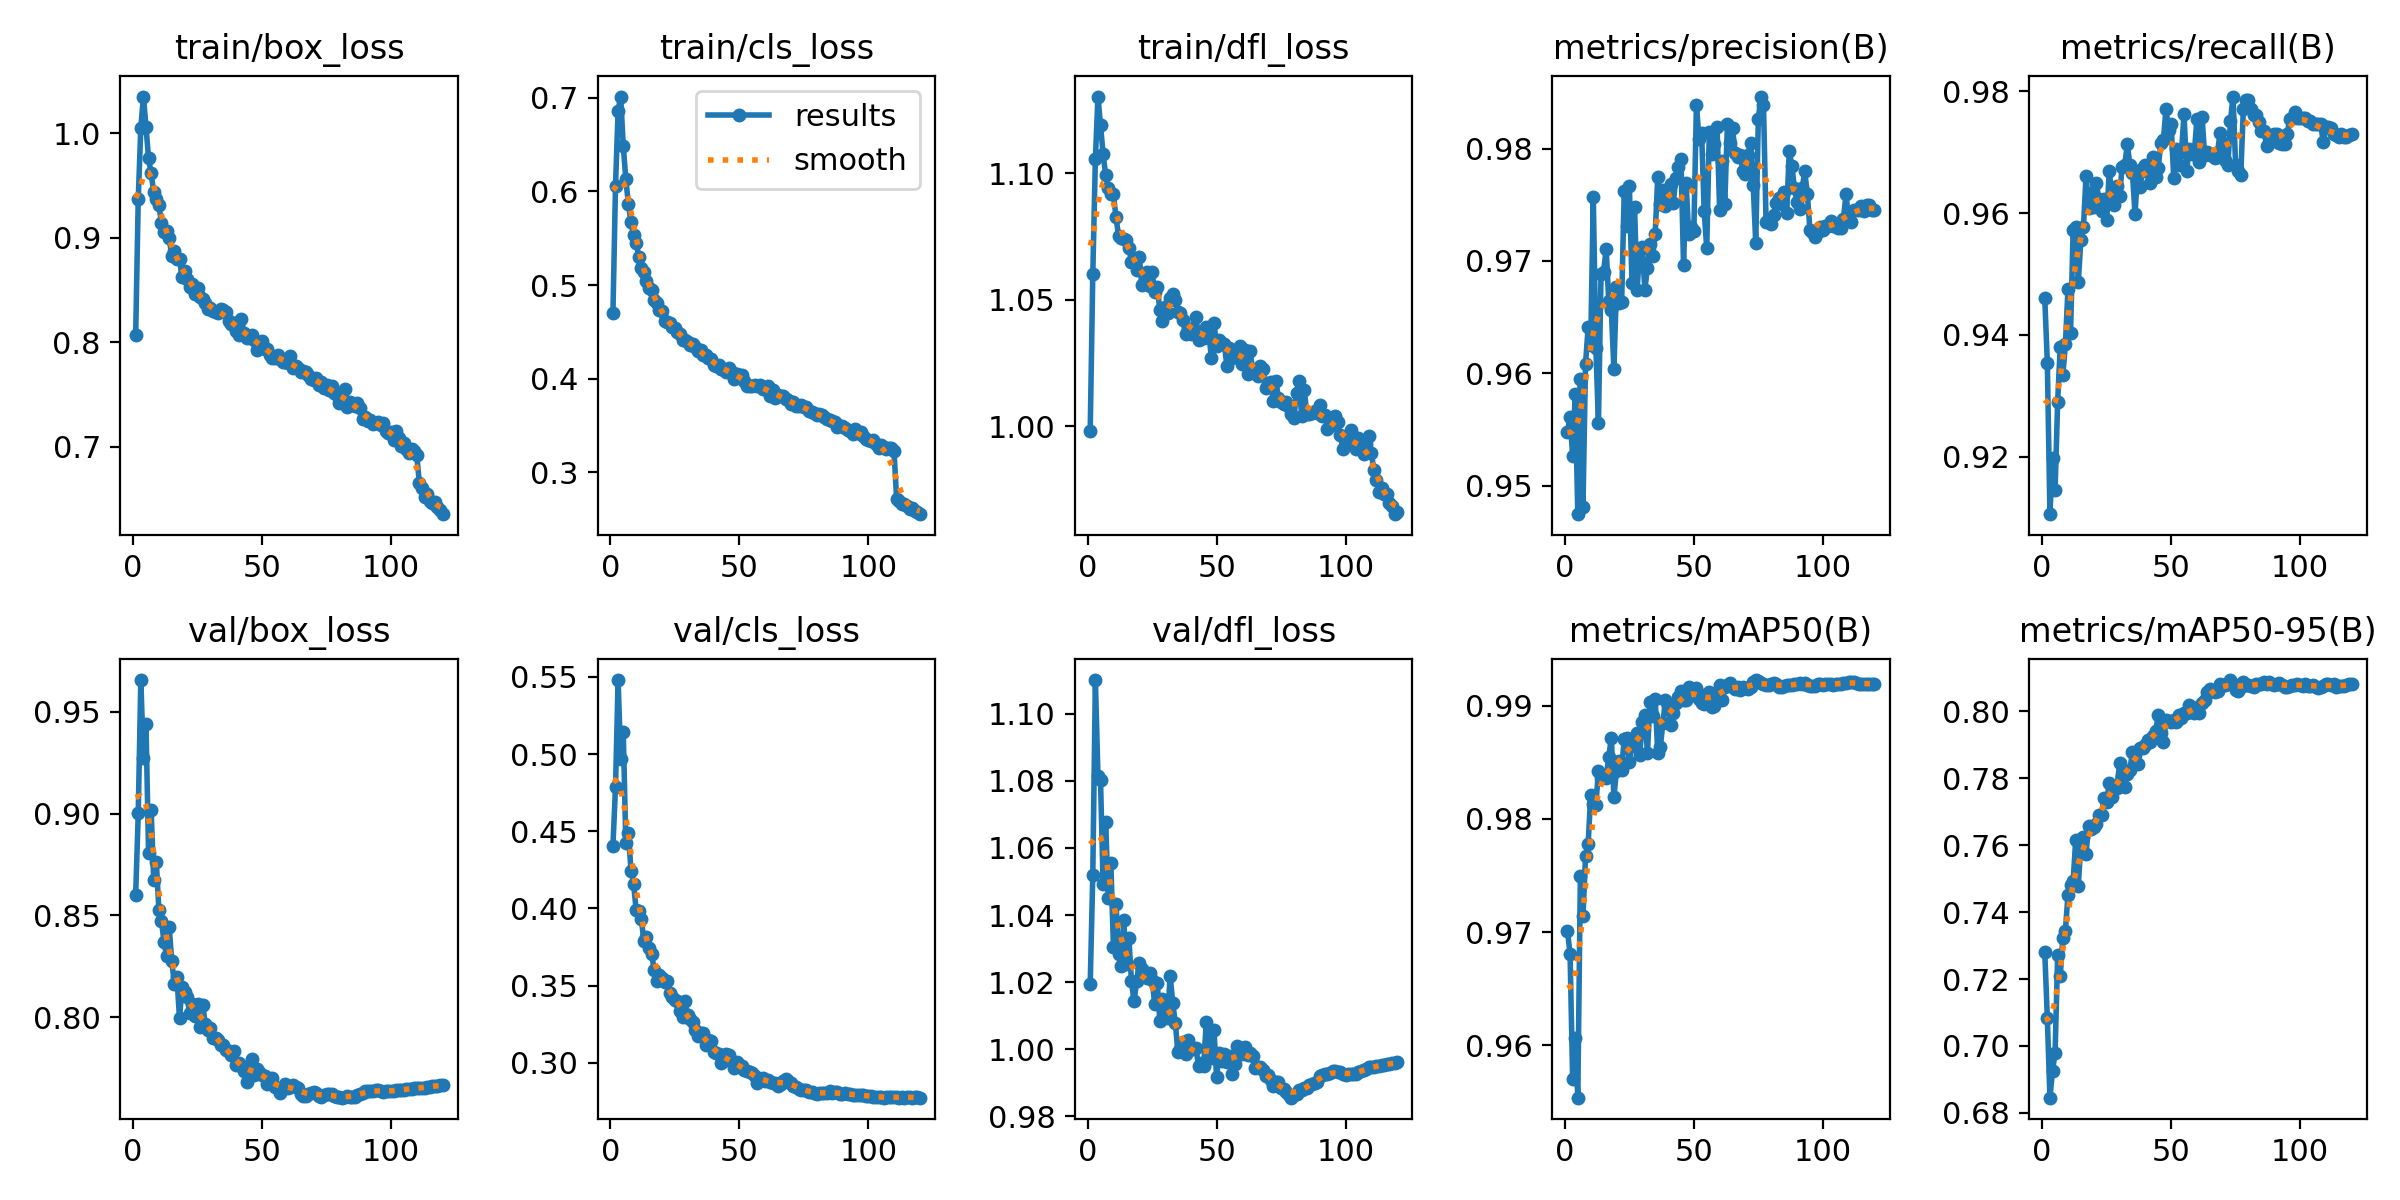

In [20]:
display(Image(filename="../runs/train/results.png"))

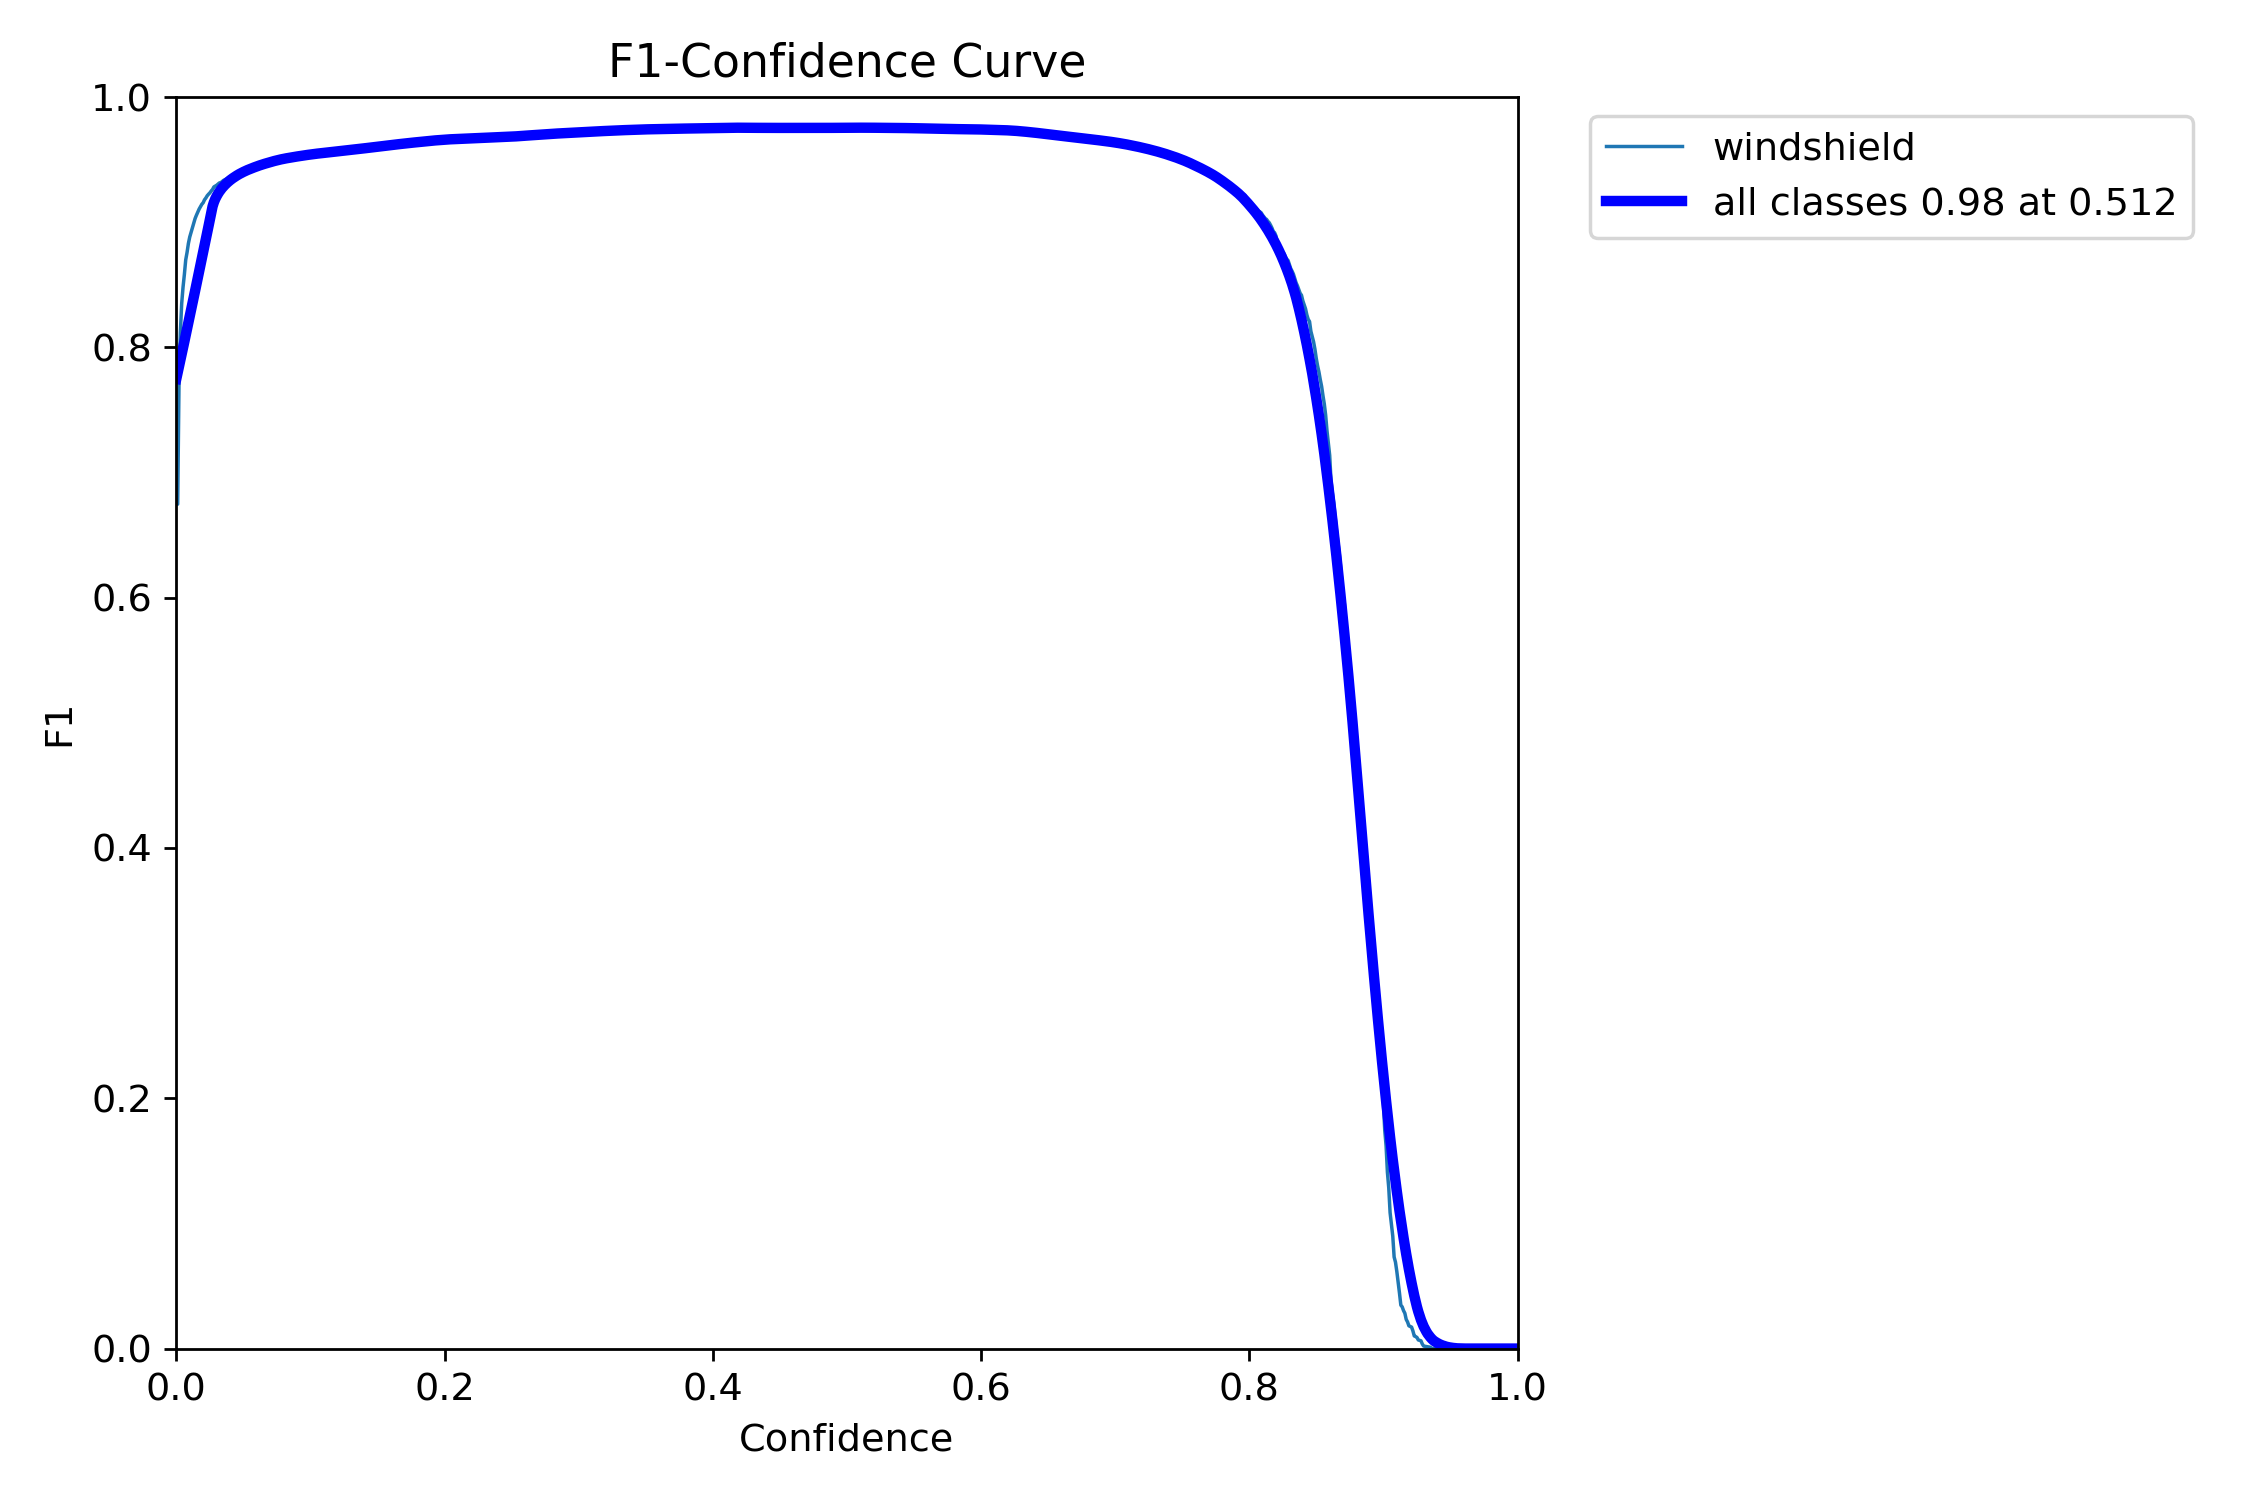

In [23]:
display(Image(filename="../runs/train/F1_curve.png"))

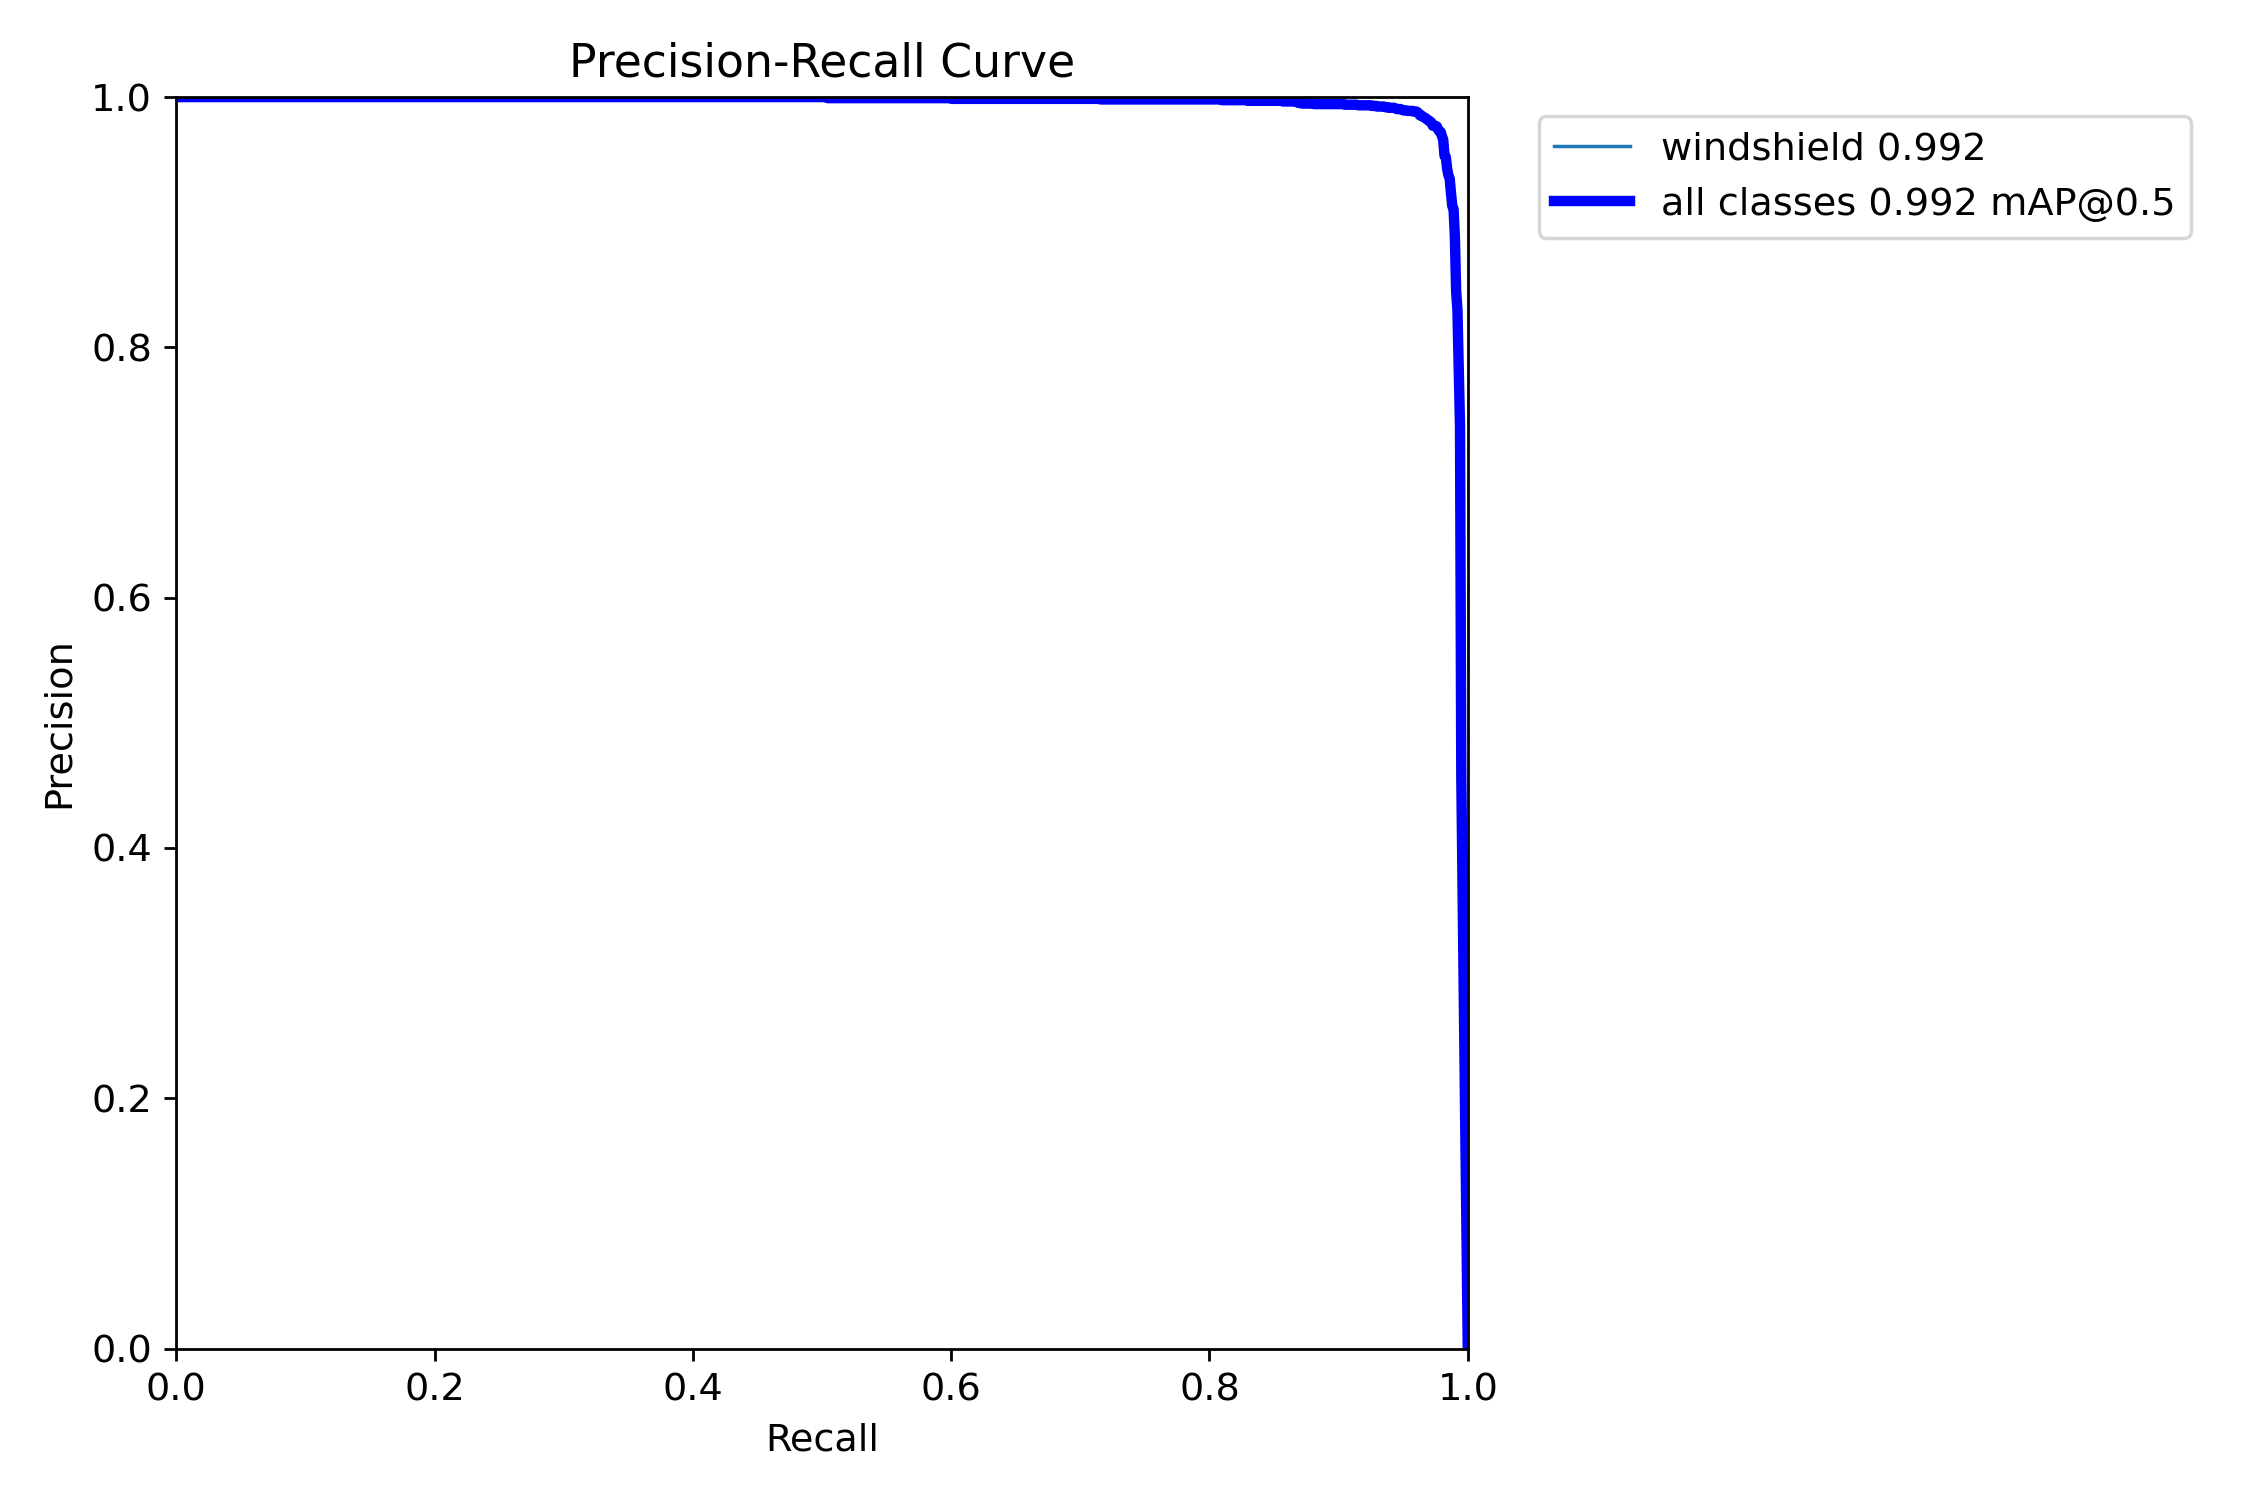

In [22]:
display(Image(filename="../runs/train/PR_curve.png"))

### Precision, Recall, and mAP
These metrics indicate the model's accuracy in detecting objects. Higher values suggest better performance:
- **Precision:** How many detected objects are correct.
- **Recall:** How many actual objects are detected.
- **mAP (Mean Average Precision):** A combined measure of precision and recall across all confidence thresholds.

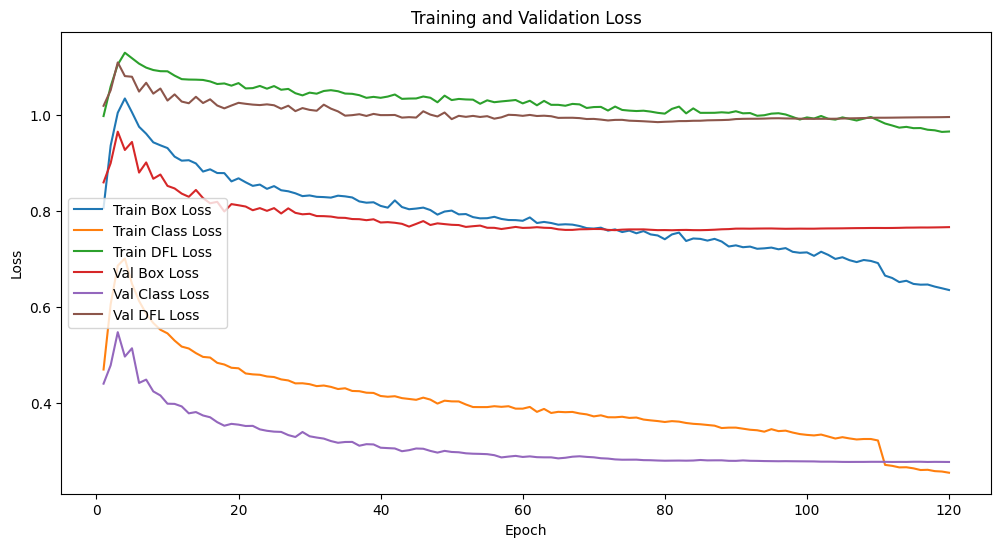

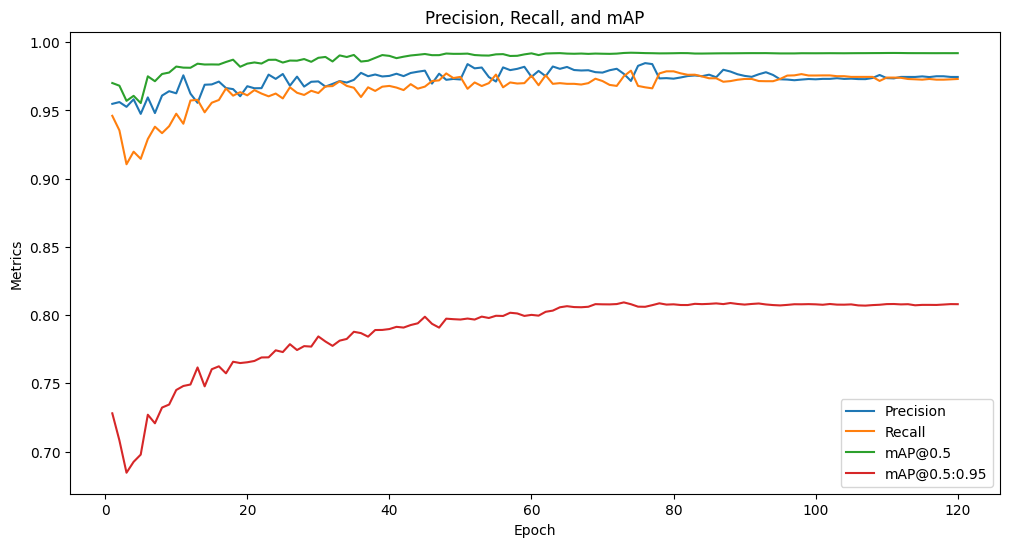

In [25]:
# Load training results
results_path = '../runs/train/results.csv'  # adjust the path as needed
df = pd.read_csv(results_path)

# Plot loss metrics
plt.figure(figsize=(12, 6))
if 'train/box_loss' in df.columns:
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
if 'train/cls_loss' in df.columns:
    plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
if 'train/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
if 'val/box_loss' in df.columns:
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
if 'val/cls_loss' in df.columns:
    plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
if 'val/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot precision, recall, and mAP metrics
plt.figure(figsize=(12, 6))
if 'metrics/precision(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
if 'metrics/recall(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
if 'metrics/mAP50(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
if 'metrics/mAP50-95(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and mAP')
plt.legend()
plt.show()


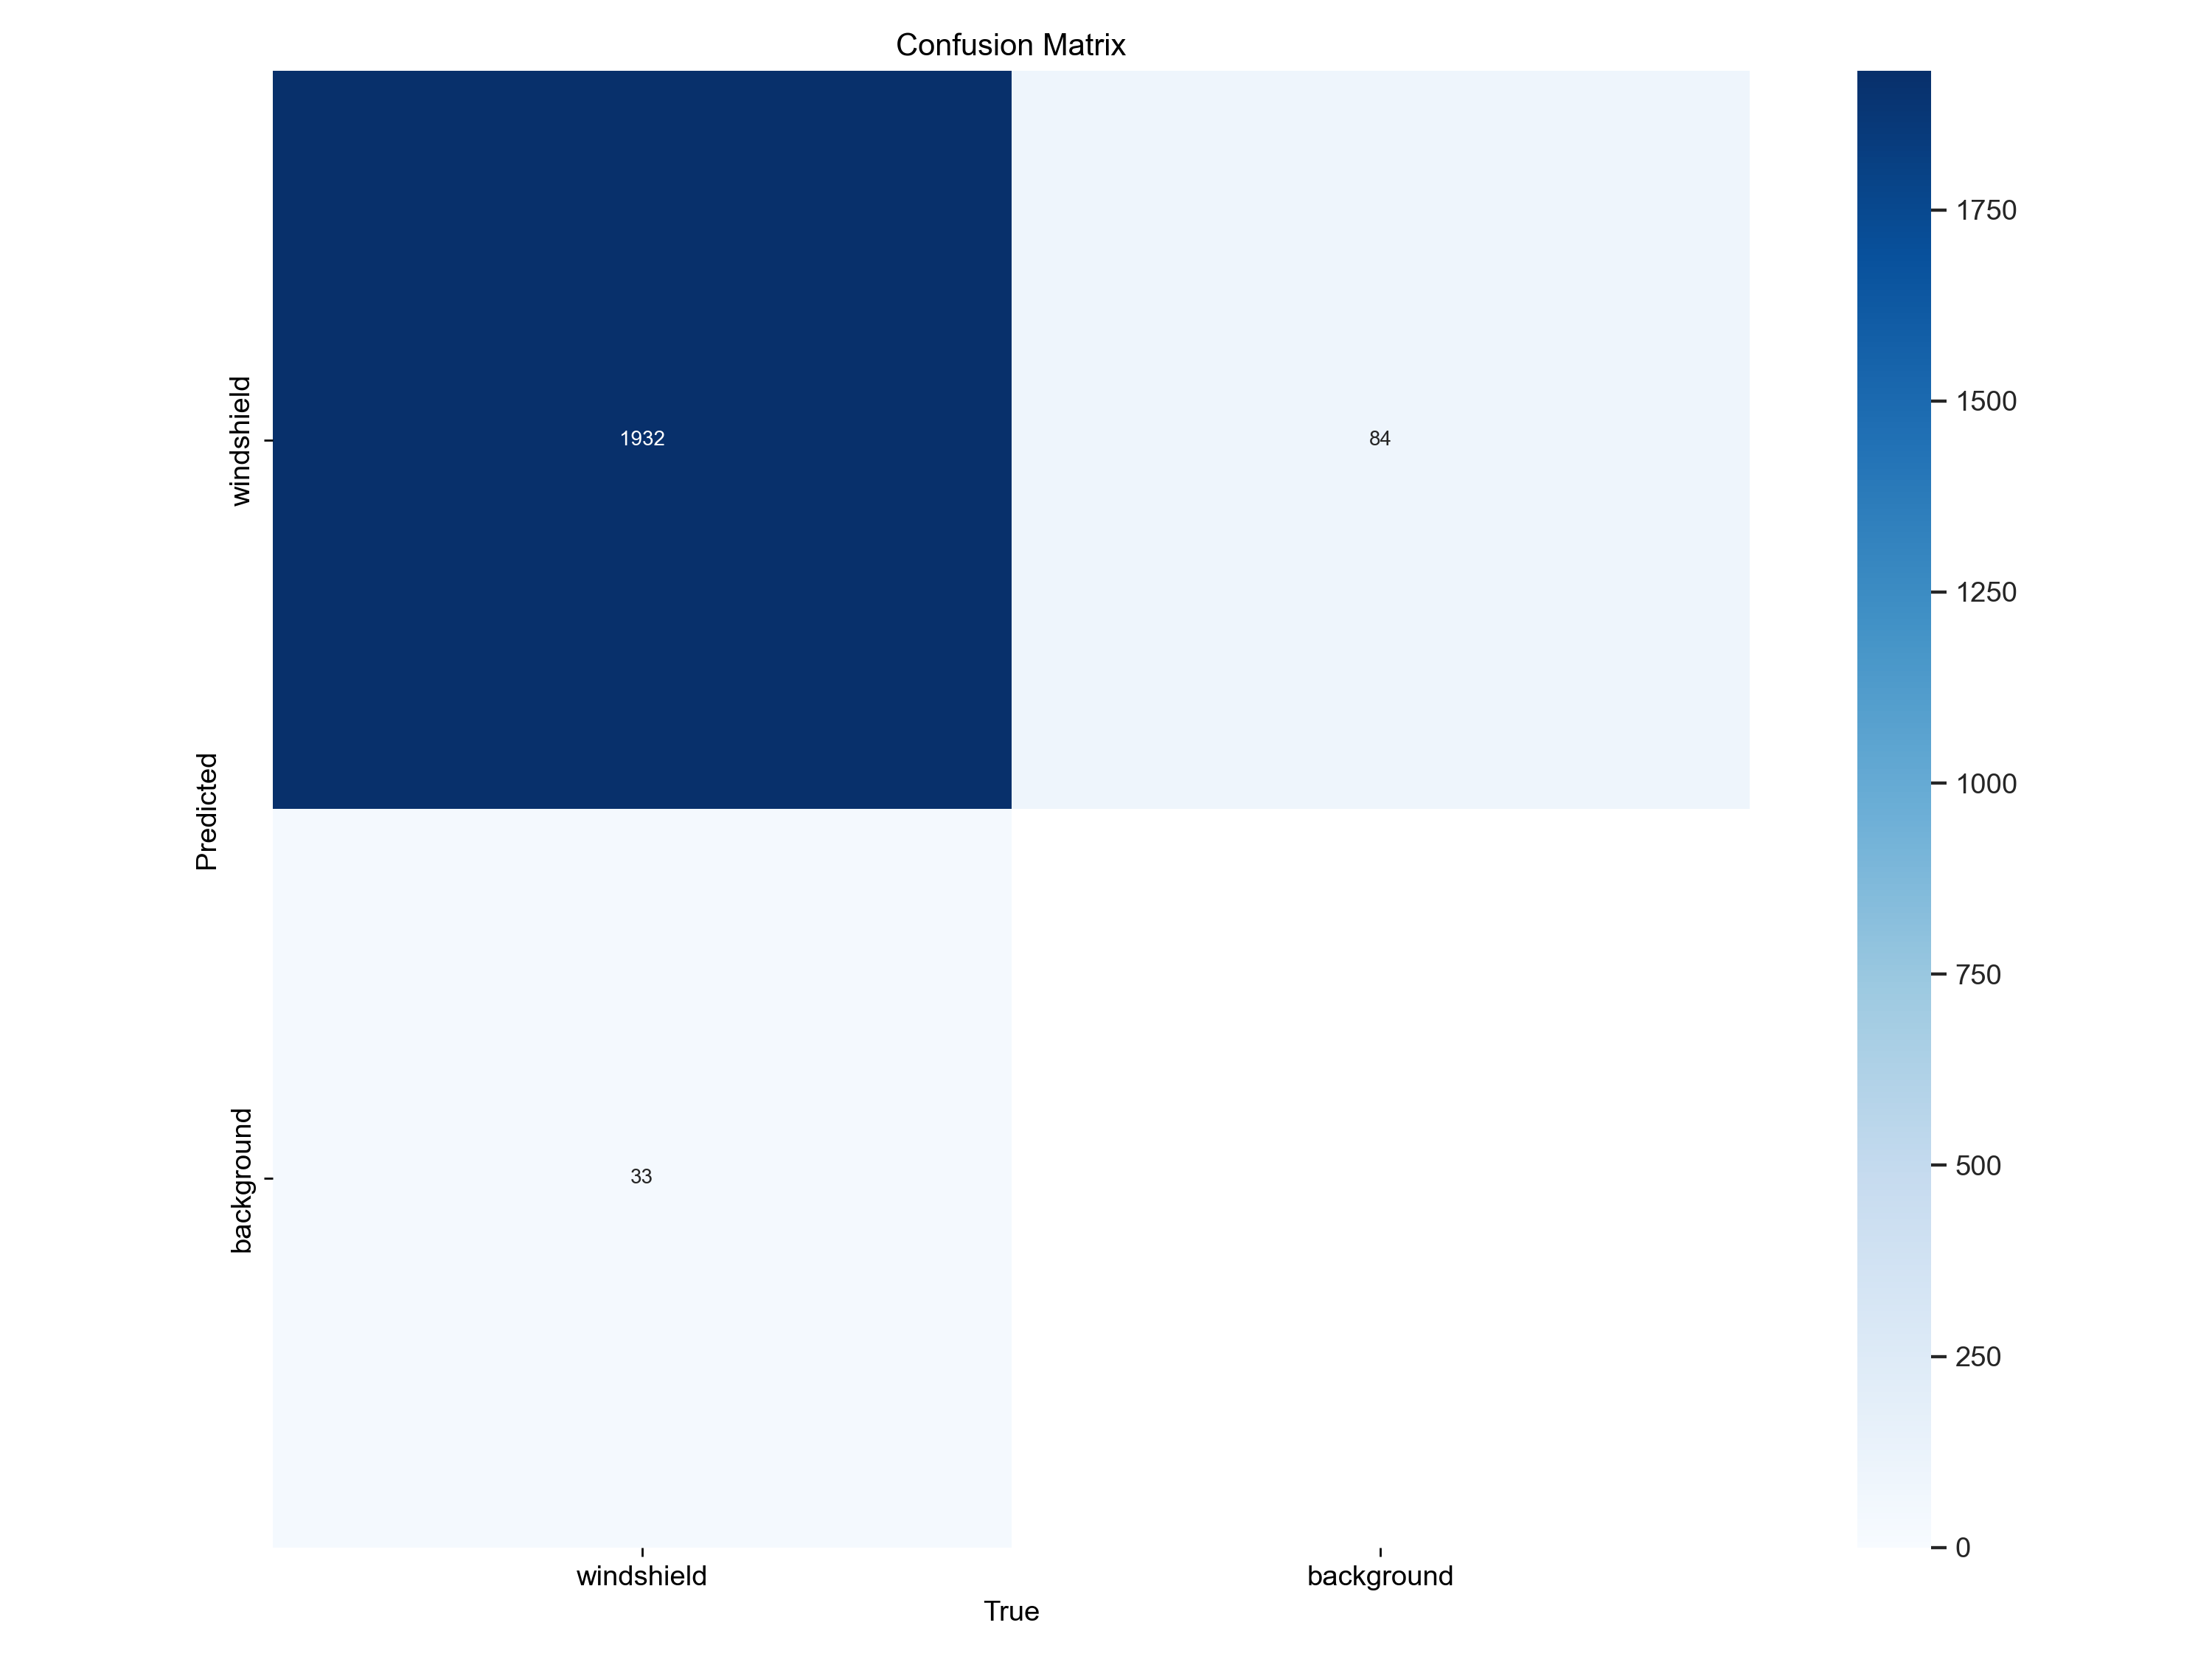

In [26]:
display(Image(filename="../runs/train/confusion_matrix.png"))

In [27]:
# Load the model
model = YOLO("../runs/train/weights/best.pt")

## Model Validation

Validation is performed to assess the model's performance on unseen data. 
Metrics such as precision, recall, and mAP are calculated, and results are visualized with confusion matrices and performance curves.


In [28]:
results_val = model.val(
    data="data.yaml",
    task="detect",
    device=device,
    split="val",
    project="../runs",
    name="val_results"
)


Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\Tamer\ML_Material\Proj\seatbelt_detection\yolo_images\valid\labels.cache... 1499 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1499/1499 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1965. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:07<00:00, 12.05it/s]


                   all       1499       1965      0.975      0.978      0.992      0.809
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to ..\runs\val_results


# Validation Set Evaluation

## 1. F1-Confidence Curve
- The F1 score evaluates the balance between precision and recall.  
- **Peak F1 Score:** 0.98 at a confidence threshold of 0.416.
- The F1 curve is stable across a wide range of thresholds (approximately 0.3 to 0.6), indicating that the model is consistently achieving high precision and recall.  
-For most applications, a threshold around 0.4 is optimal.


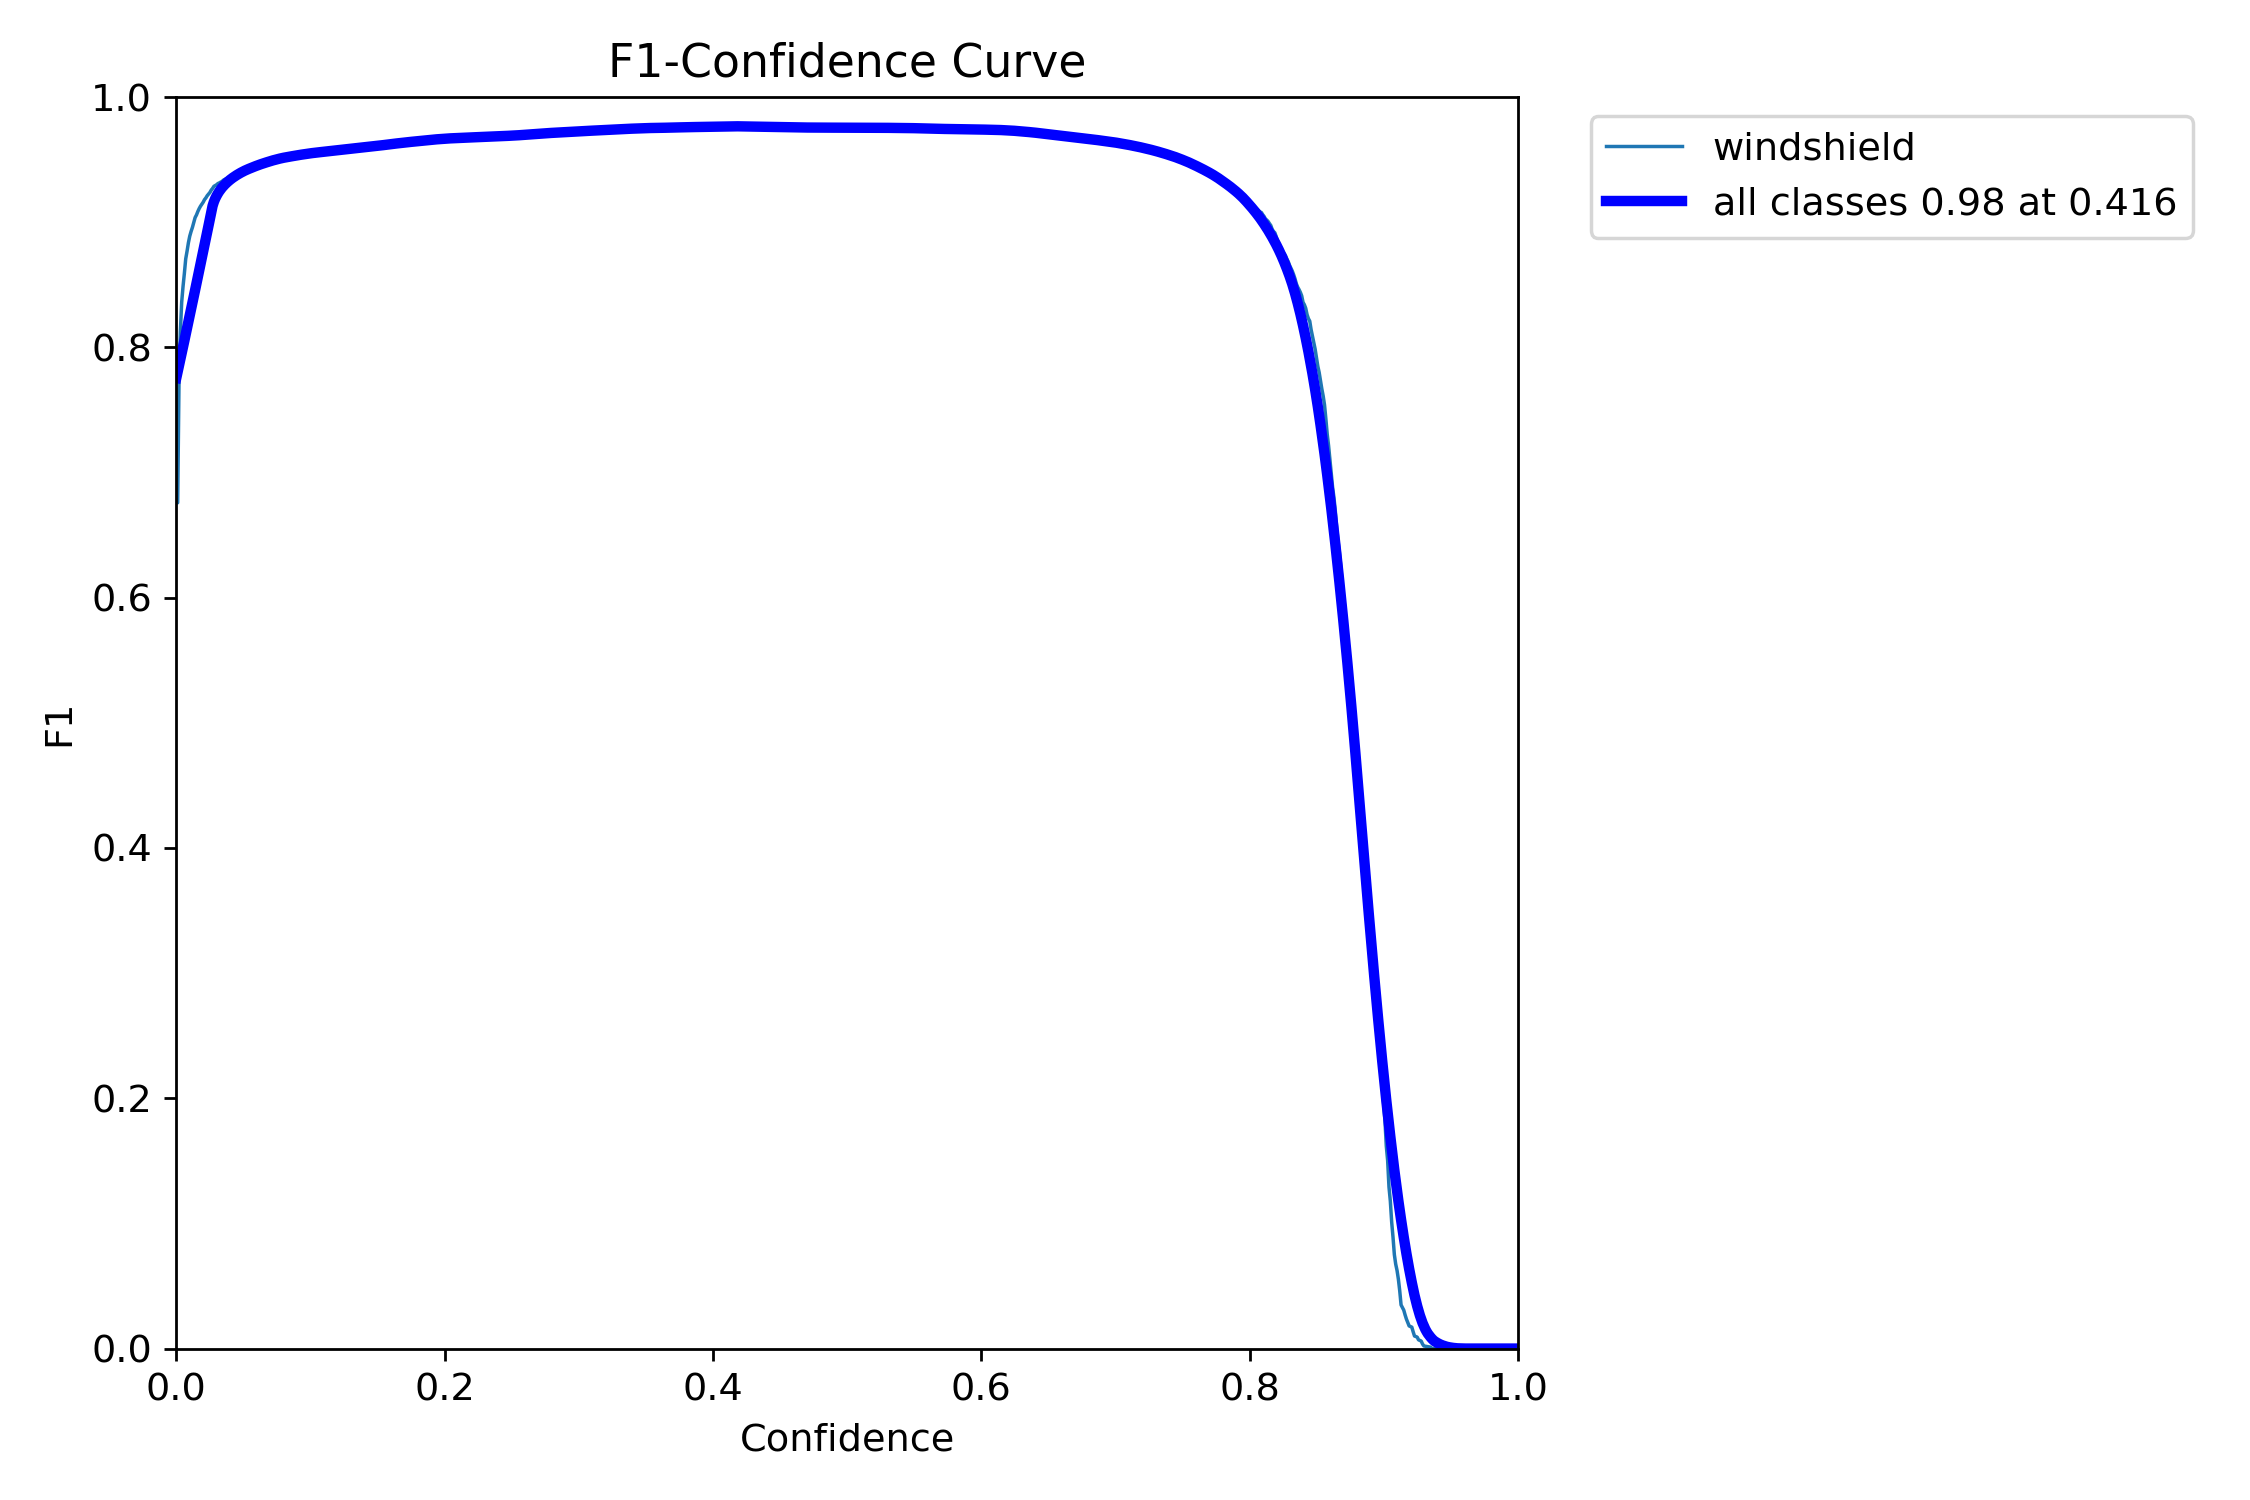

In [29]:
display(Image(filename="../runs/val_results/F1_curve.png"))

## 2. Precision-Confidence Curve
- Precision measures how many of the model's predictions are correct.  
- **Maximum Precision:** 1.00 at a confidence threshold of 0.889.  
- The precision curve shows a consistent increase as the confidence threshold rises. At higher thresholds, the model becomes more conservative, reducing false positives.  
- **Insight:** If avoiding false positives is critical, consider using a confidence threshold >0.8. However, this will reduce recall.


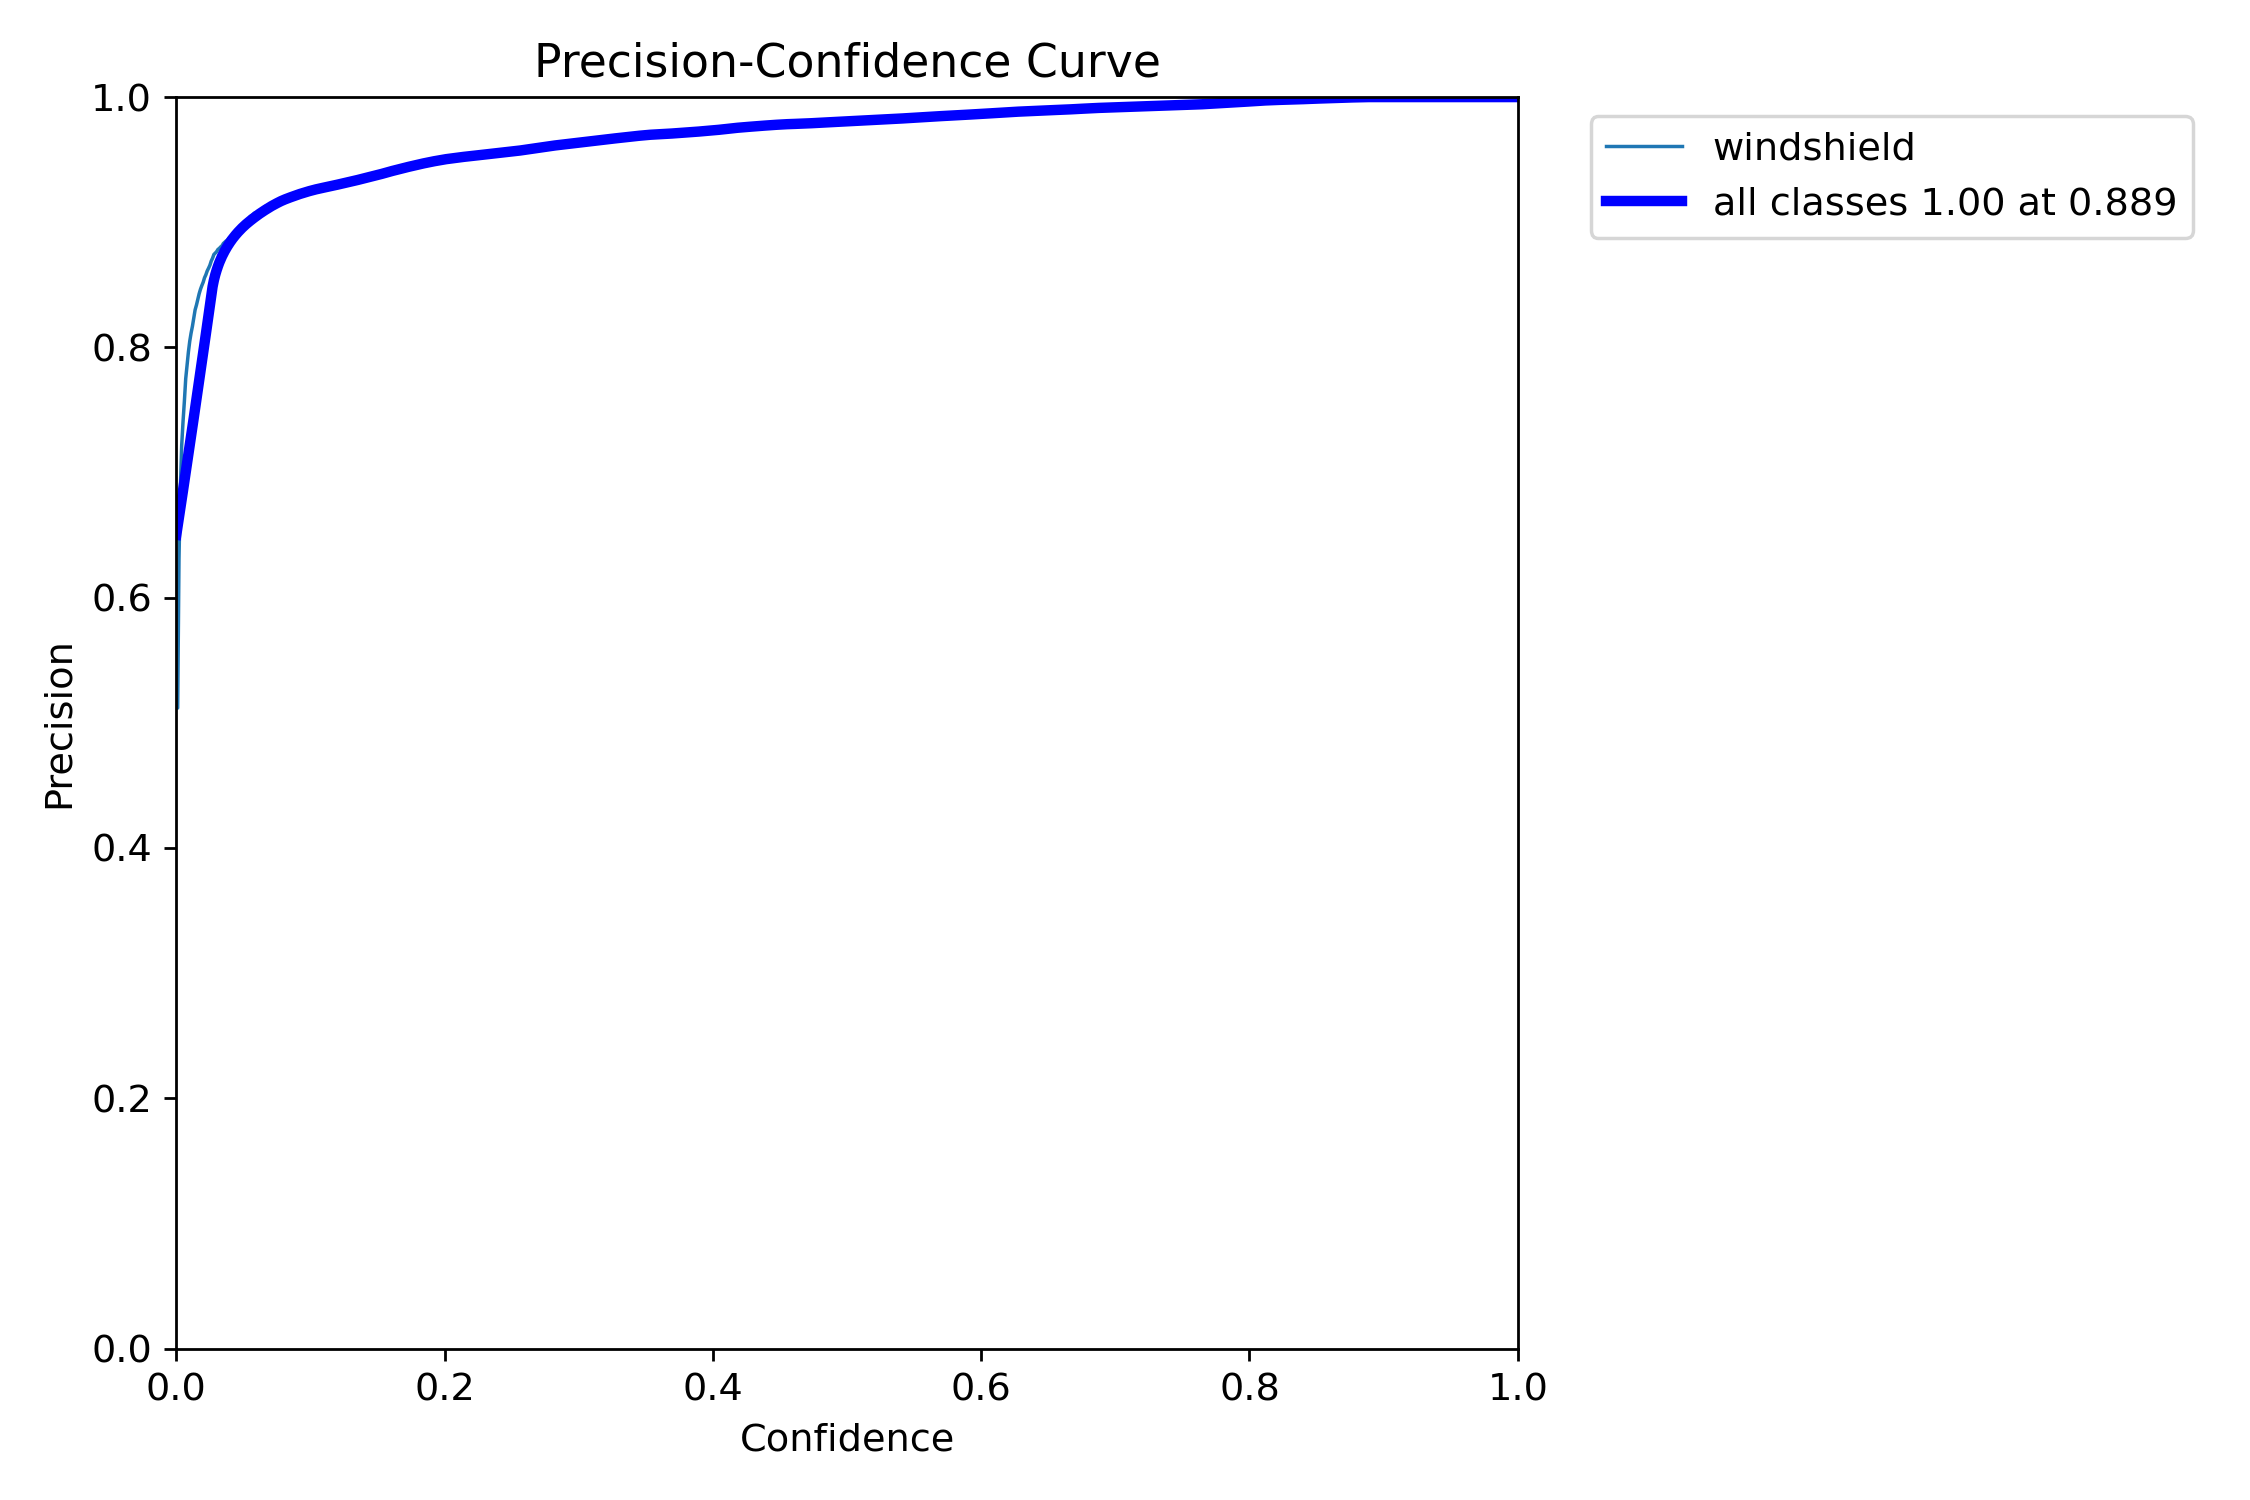

In [30]:
display(Image(filename="../runs/val_results/P_curve.png"))

## 3. Recall-Confidence Curve
- Recall measures how many of the actual objects the model detects.  
- **Maximum Recall:** Close to 1.0 at low confidence thresholds. Recall decreases as the confidence threshold rises because the model becomes stricter in its predictions.  
- For applications where missing detections is critical, lower the confidence threshold to increase recall.


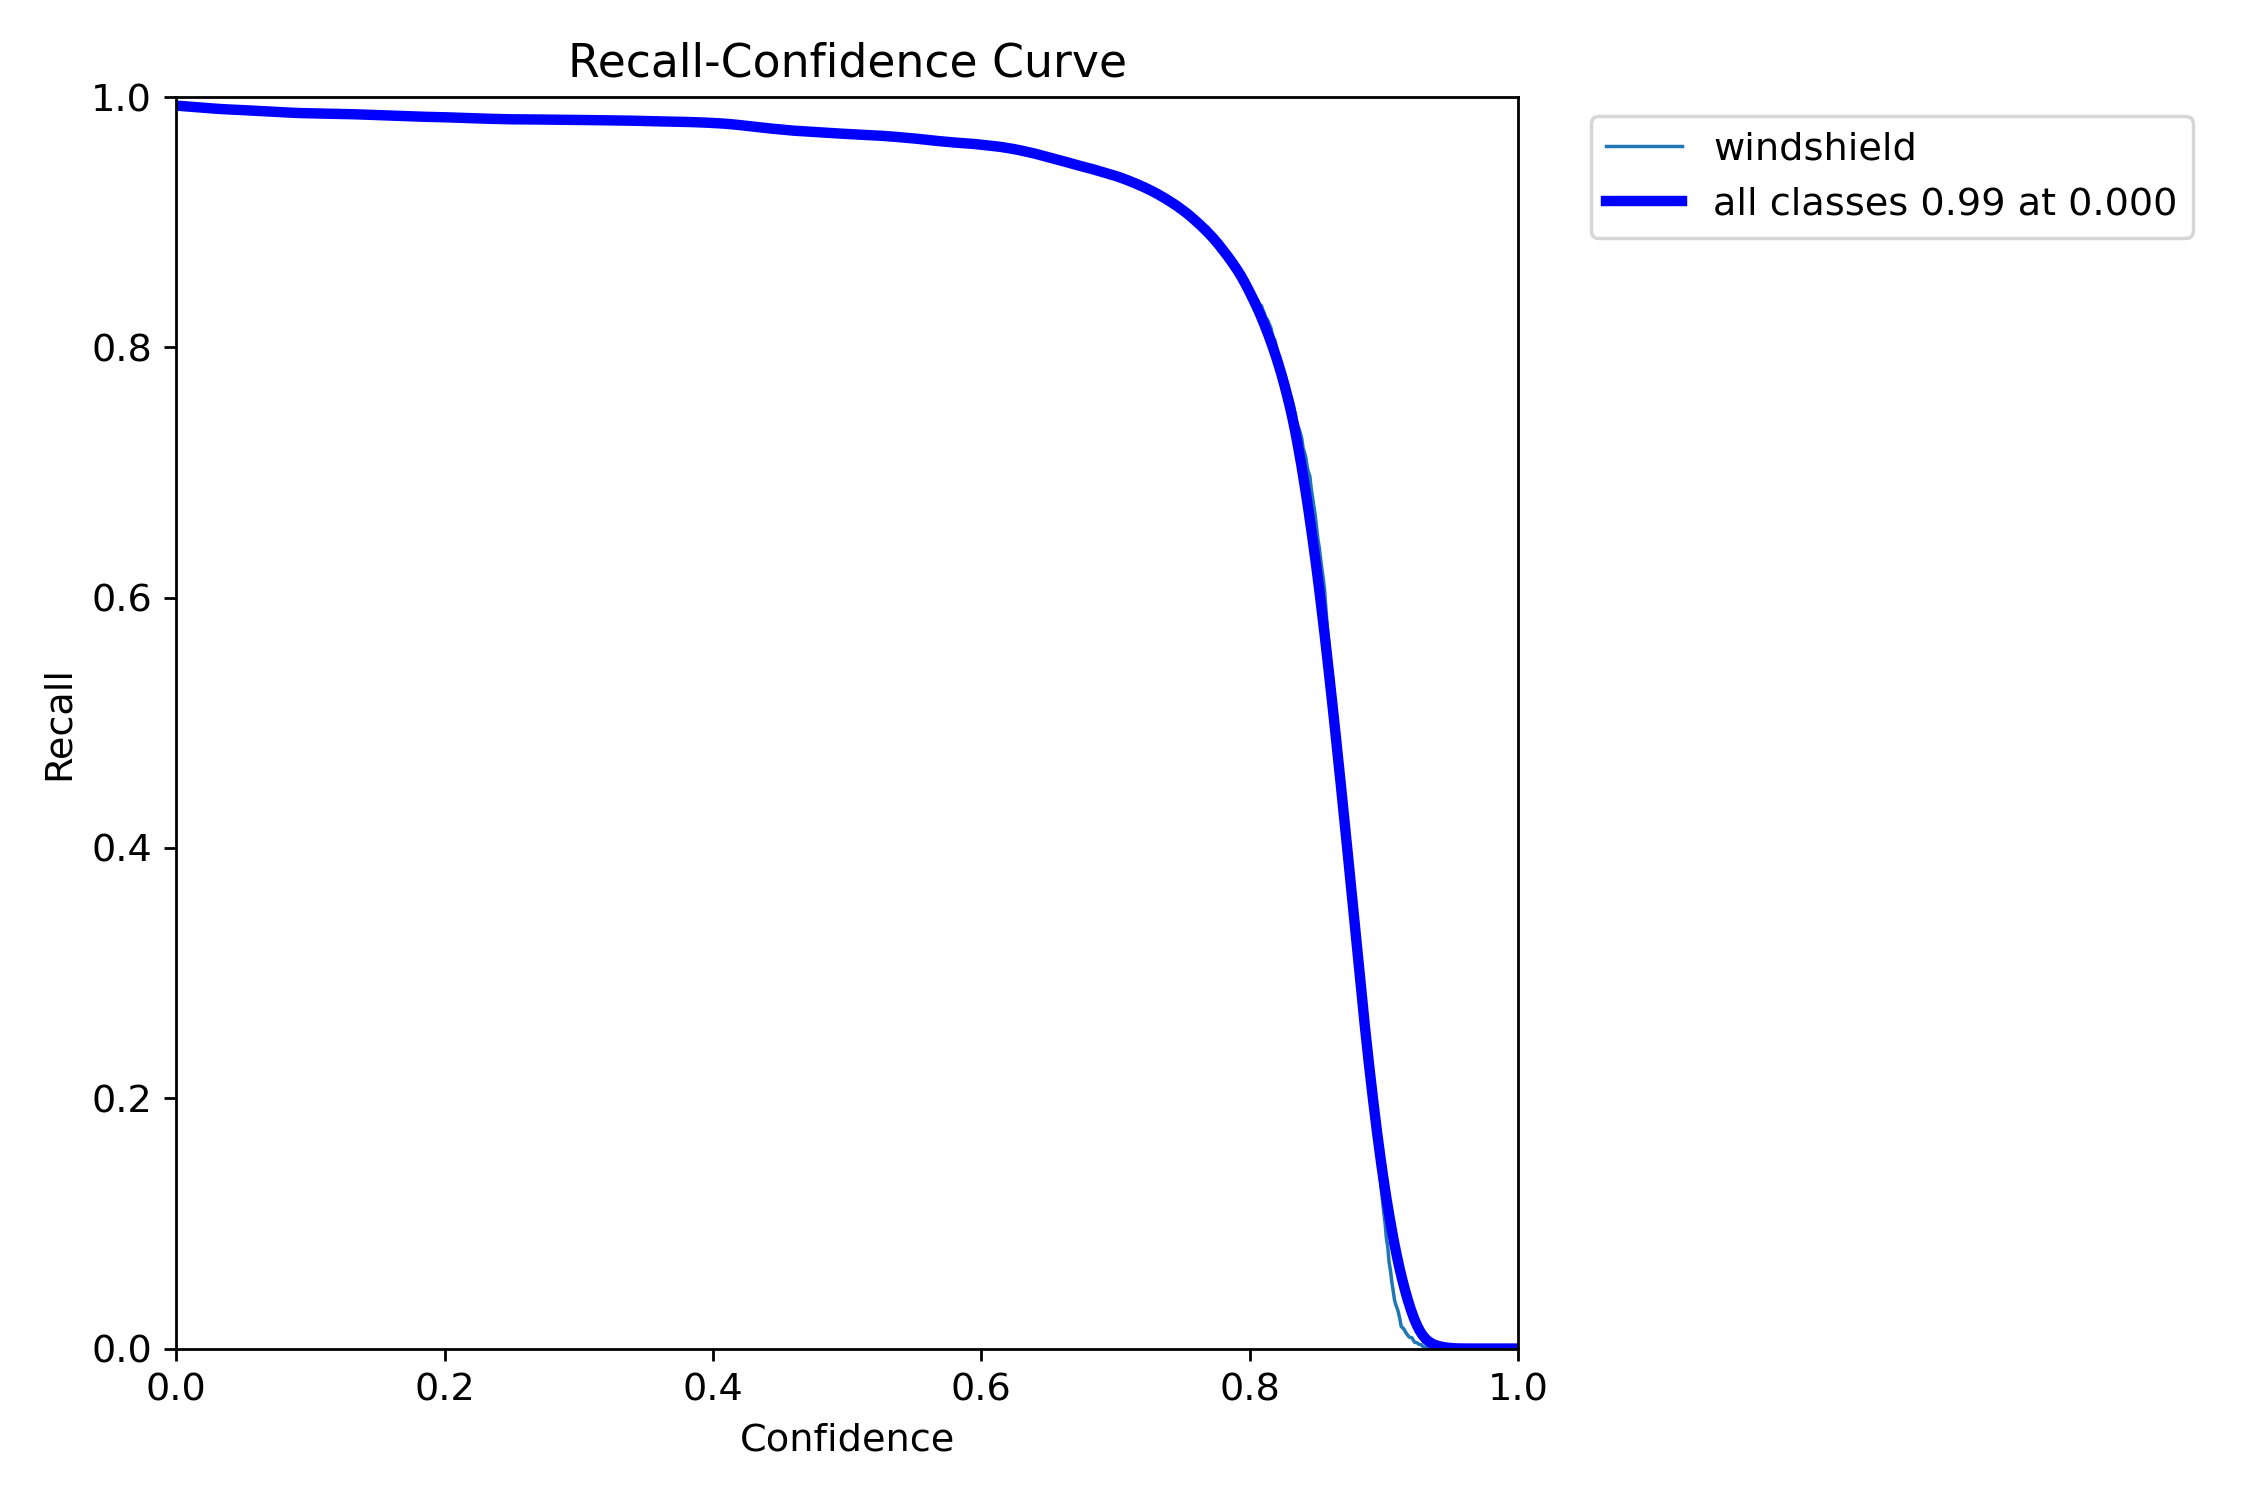

In [31]:
display(Image(filename="../runs/val_results/R_curve.png"))

## 4. Confusion Matrix
- The confusion matrix summarizes the model's predictions:
  - **True Positives (TP):** 1934 correctly predicted windshields.
  - **False Positives (FP):** 83 background instances incorrectly classified as windshields.
  - **False Negatives (FN):** 31 windshields missed by the model.
  - The model achieves a high recall, with most windshields correctly detected.
  - A small number of false positives and false negatives remain, which could be reduced with further fine-tuning or additional data.



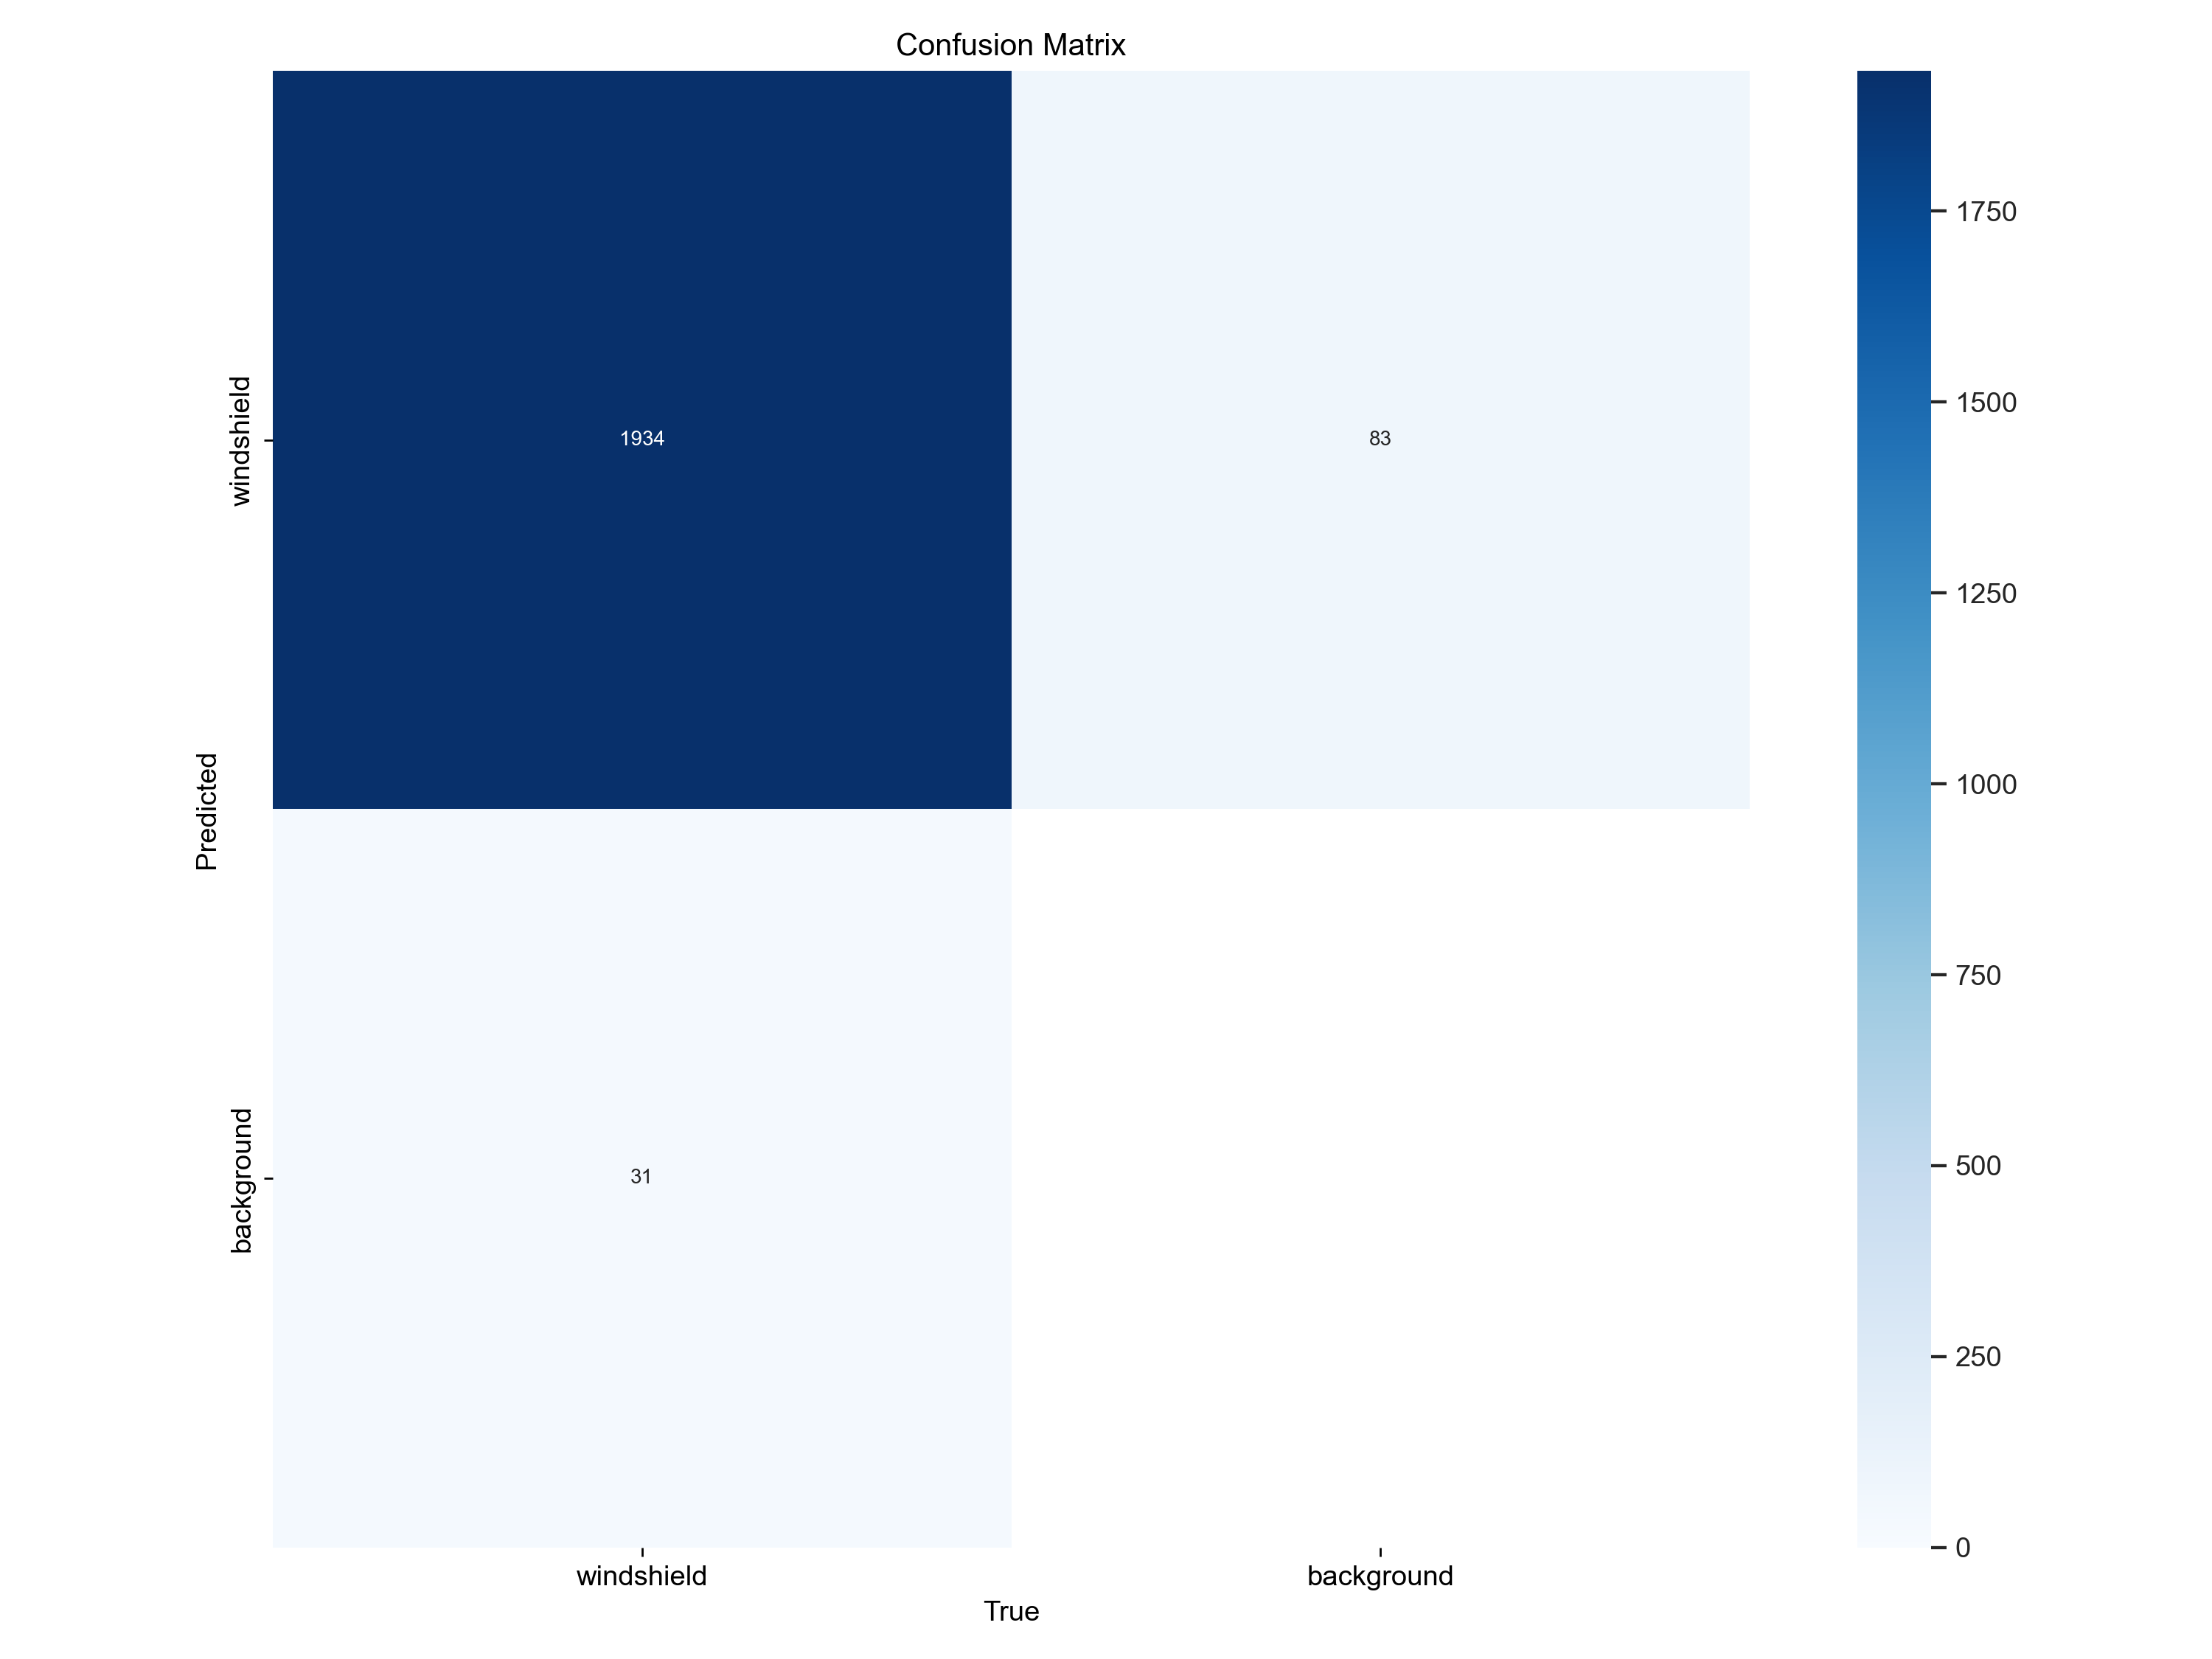

In [32]:
display(Image(filename="../runs/val_results/confusion_matrix.png"))

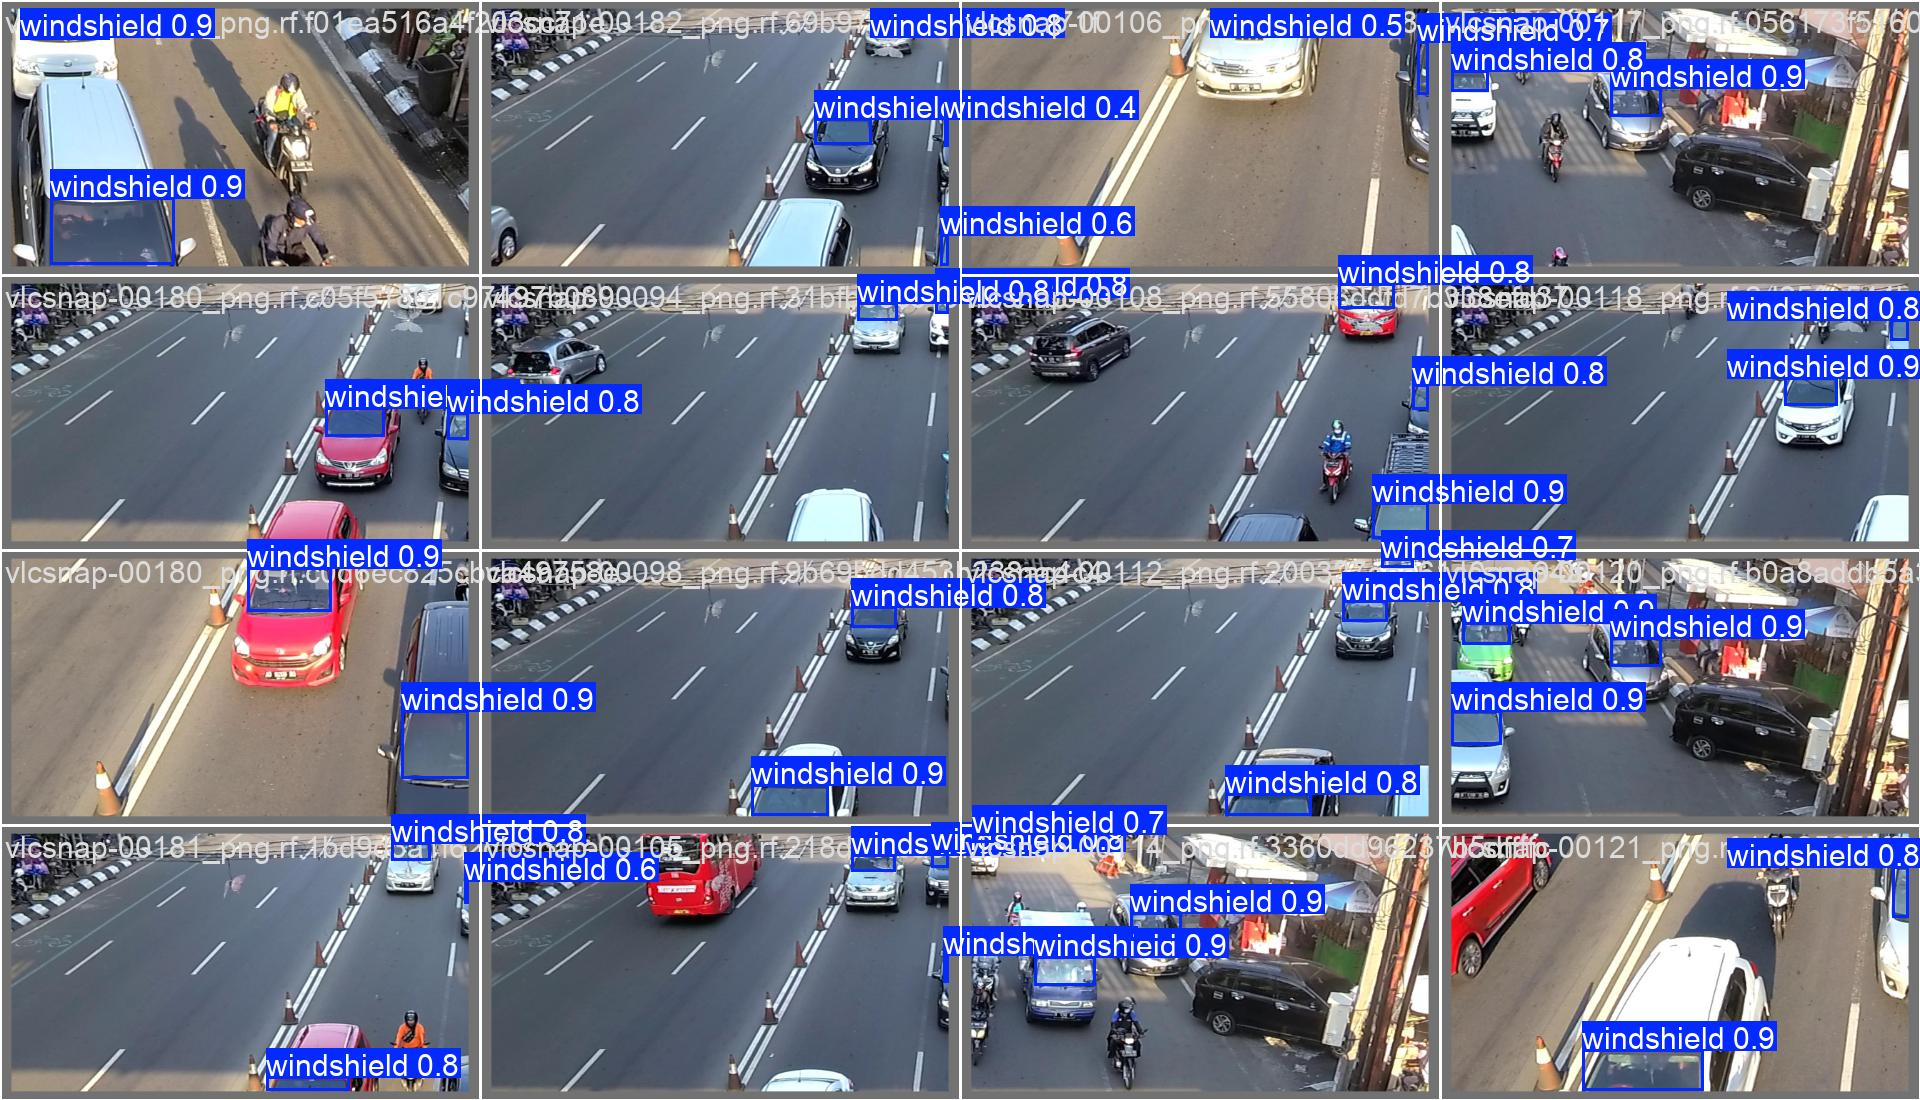

In [33]:
display(Image(filename="../runs/val_results/val_batch2_pred.jpg"))

## Model Testing on Test Set

The test set evaluation provides a final assessment of the model's performance on completely unseen data.


In [34]:
results_test = model.val(
    data="data.yaml",
    task="detect",
    device=device,
    split="val",
    project="../runs", 
    name="test_results"  
)

Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)


val: Scanning C:\Users\Tamer\ML_Material\Proj\seatbelt_detection\yolo_images\valid\labels.cache... 1499 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1499/1499 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1965. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:07<00:00, 12.39it/s]


                   all       1499       1965      0.975      0.978      0.992      0.809
Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to ..\runs\test_results


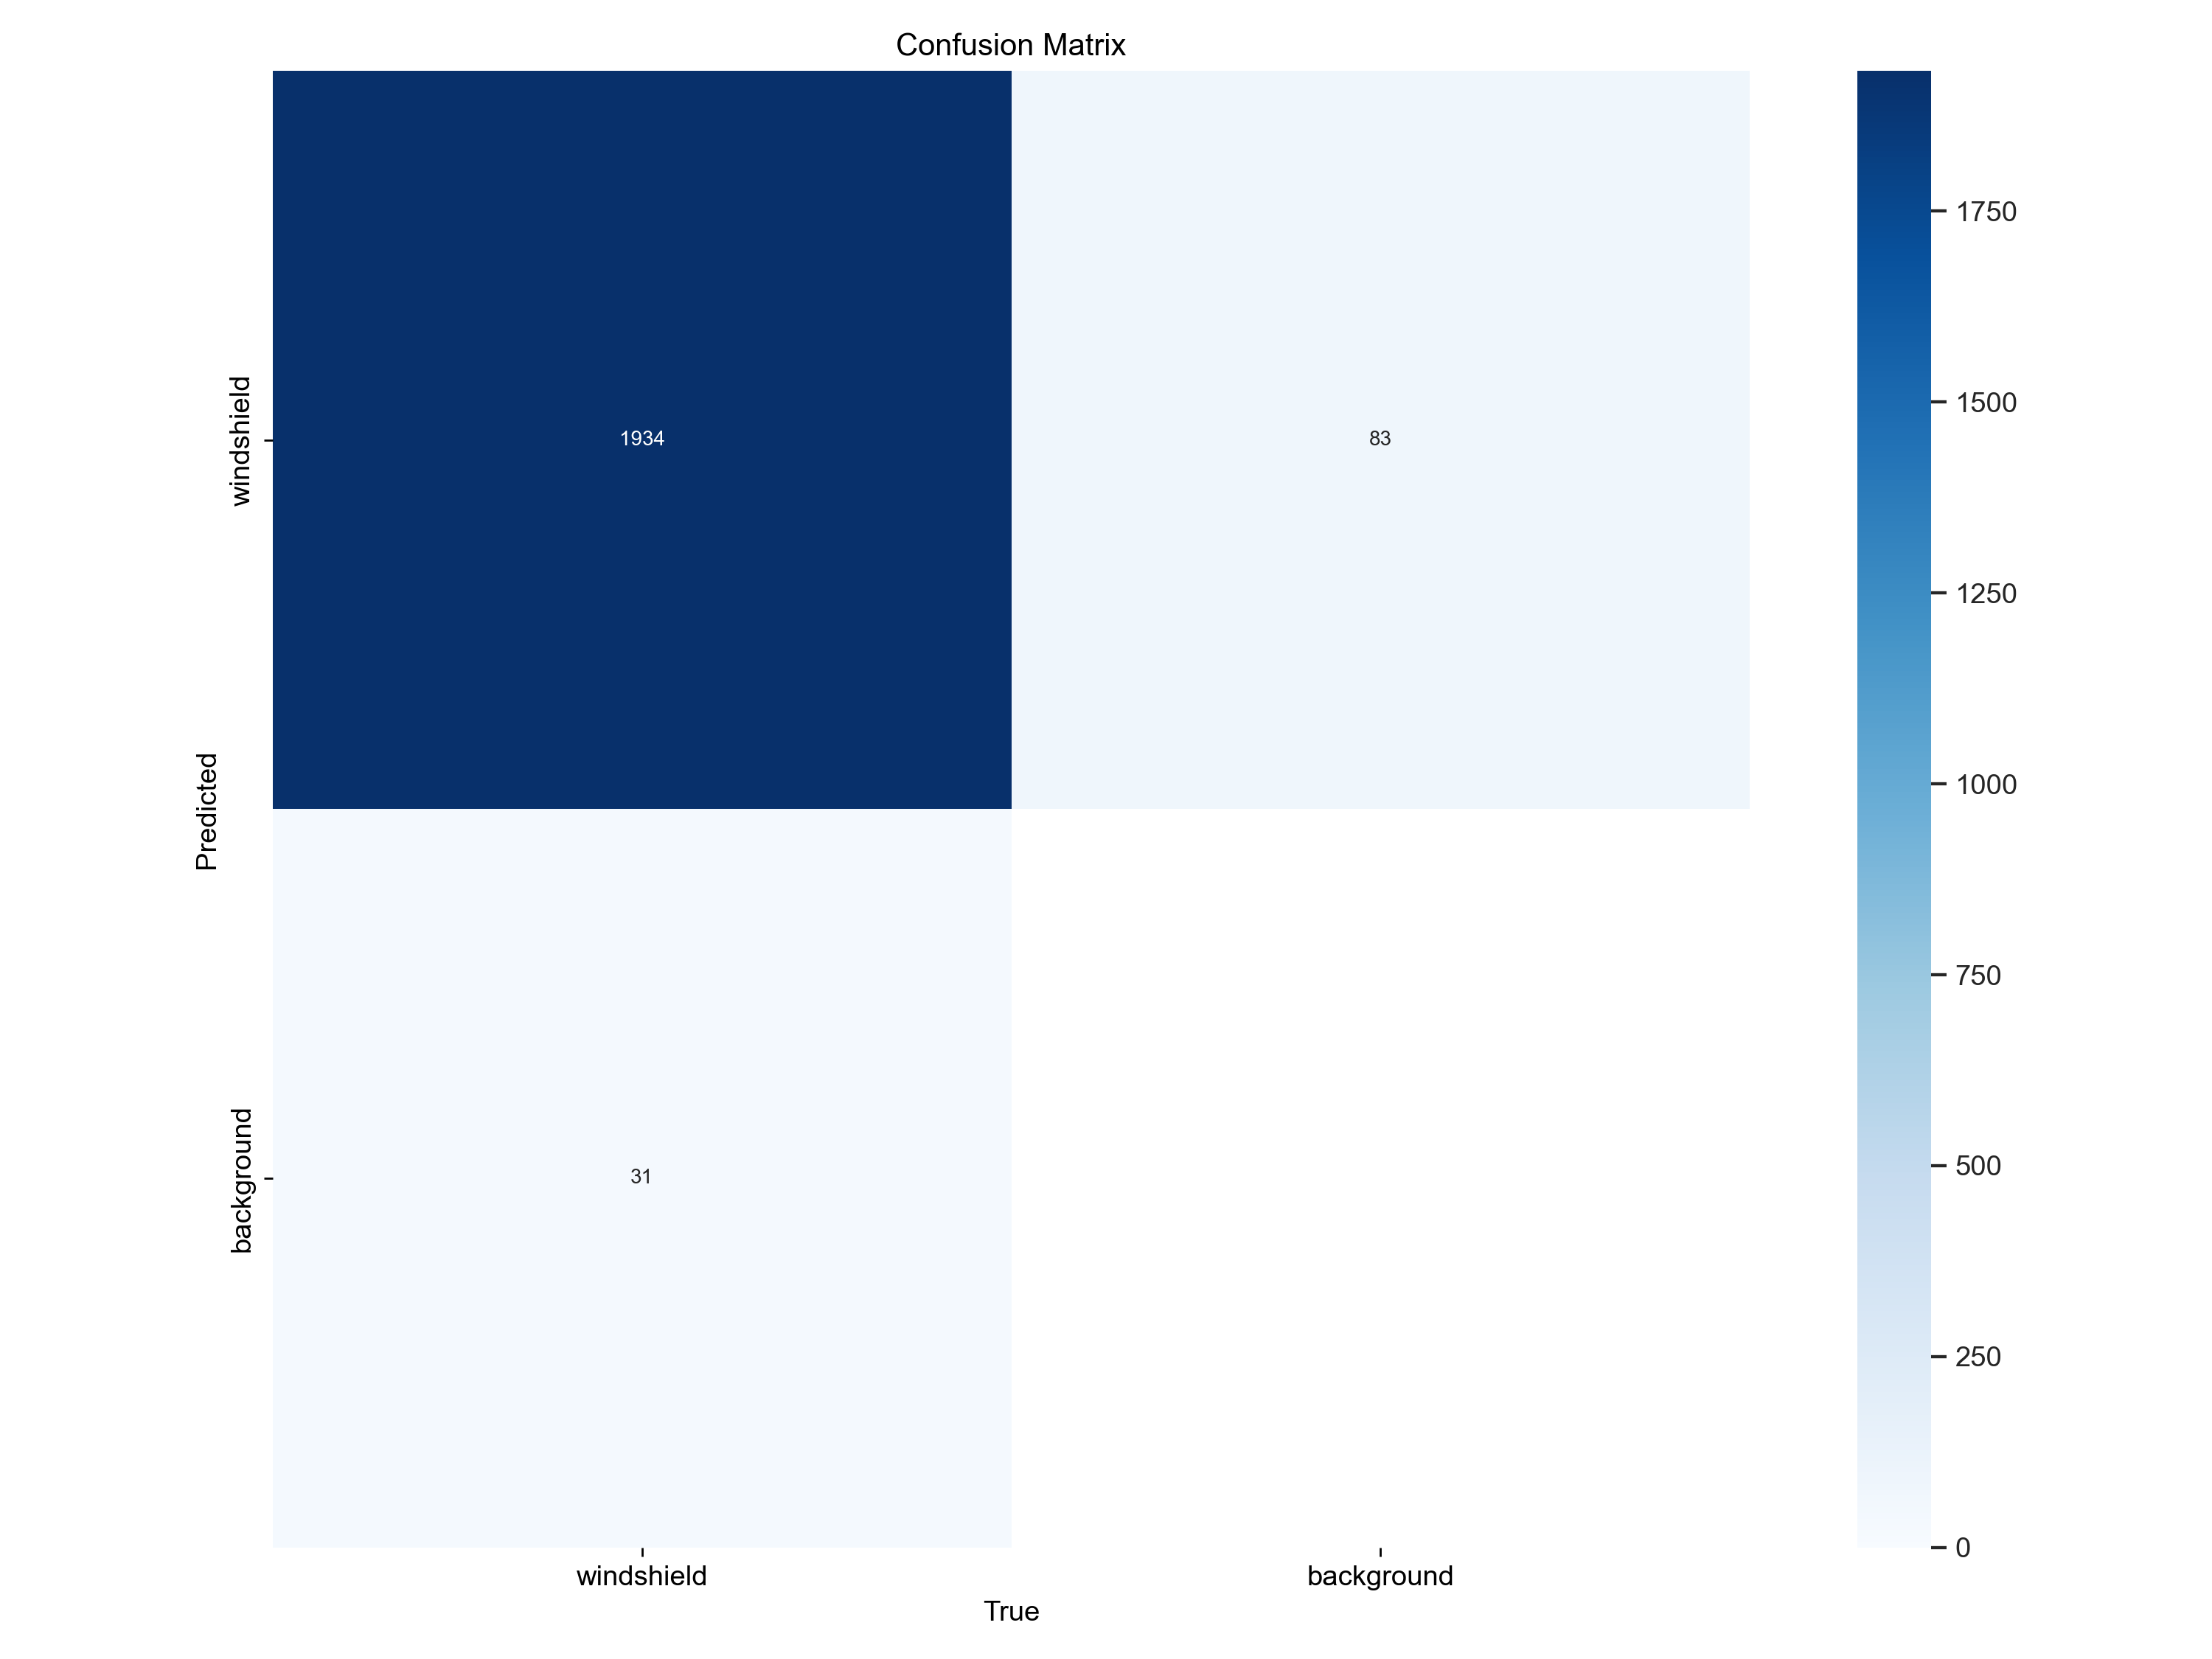

In [35]:
display(Image(filename="../runs/test_results/confusion_matrix.png"))

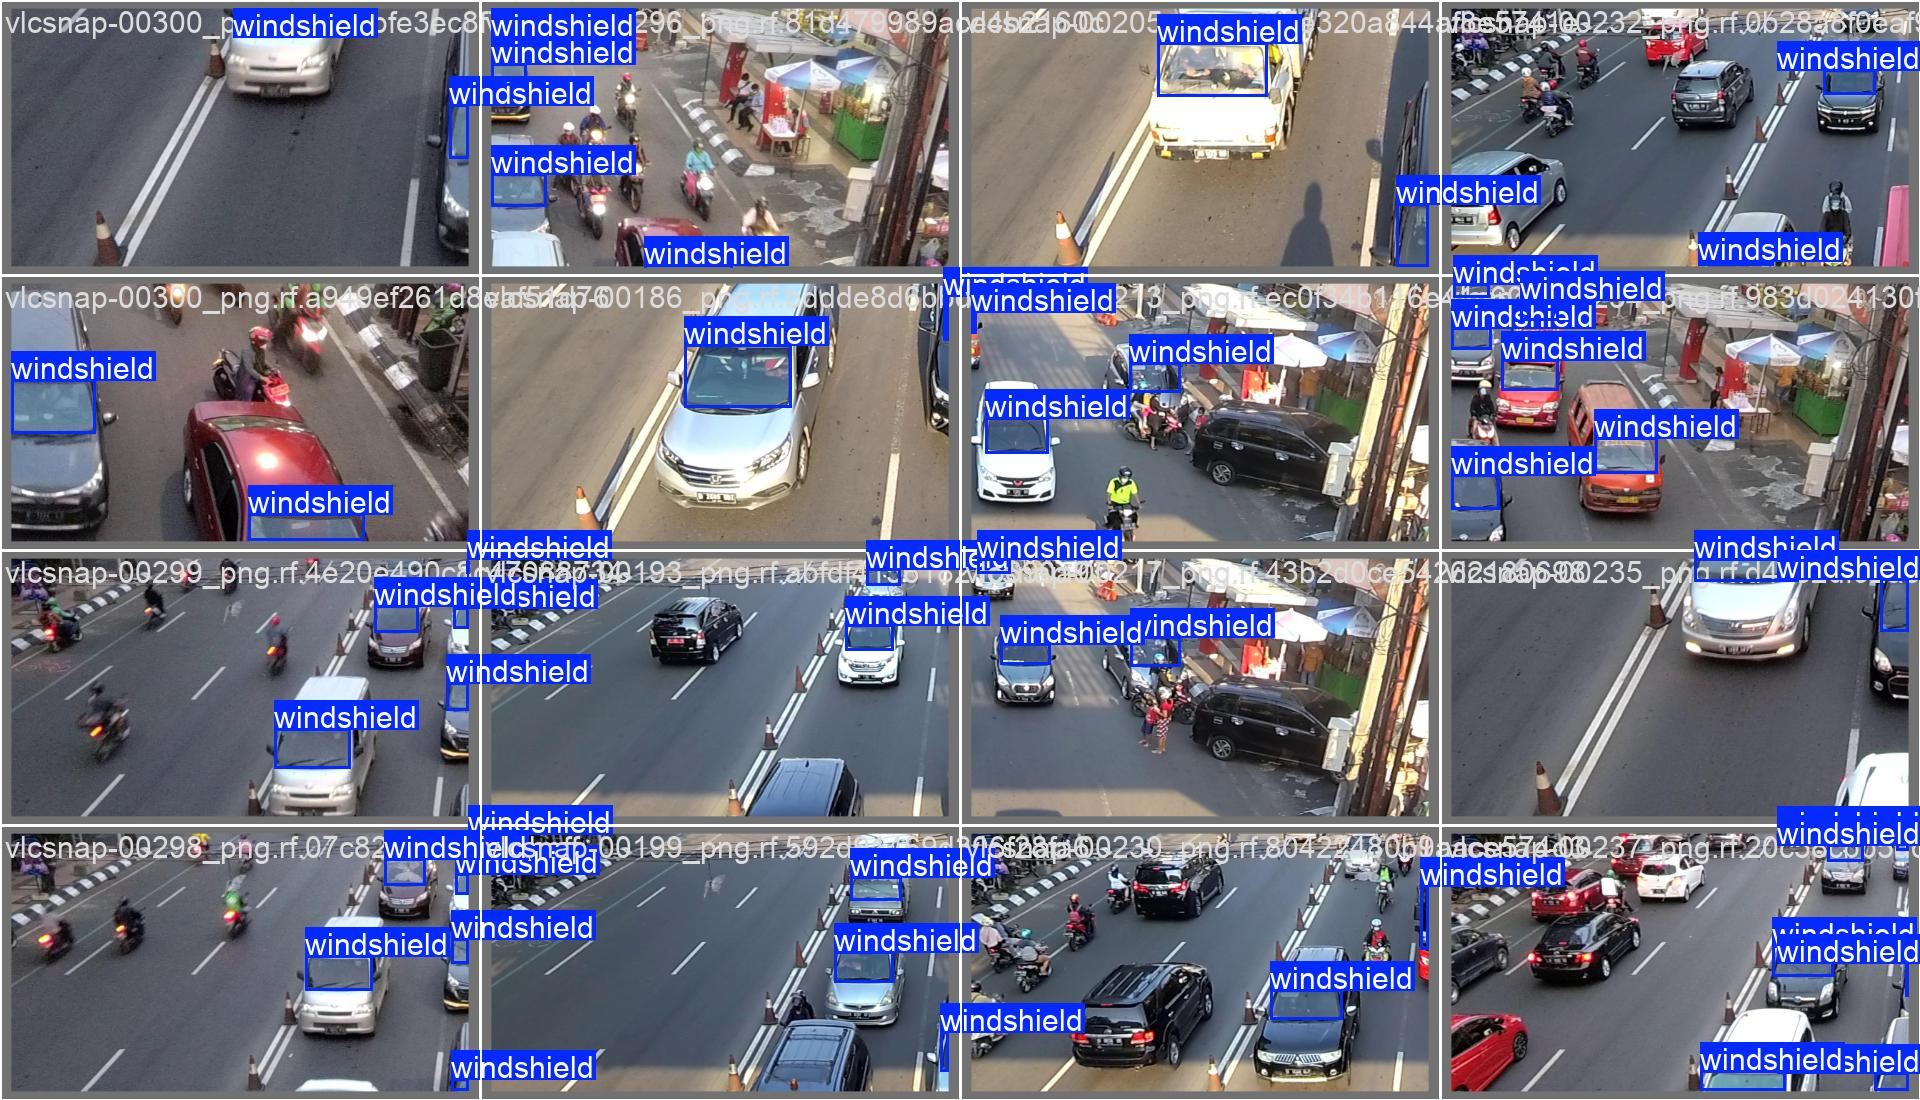

In [38]:
display(Image(filename="../runs/test_results/val_batch0_labels.jpg"))